# Week 6 - Vector Space Word Embeddings

This week, we build on last week's topic modeling techniques by taking a text corpus we have developed, specifying an underlying number of dimensions, and training a model with a neural network auto-encoder (one of Google's word2vec  algorithms) that best describes corpus words in their local linguistic contexts, and exploring their locations in the resulting space to learn about the discursive culture that produced them. Documents here are represented as densely indexed locations in dimensions, rather than sparse mixtures of topics (as in LDA topic modeling), so that distances between those documents (and words) are consistently superior, though they require the full vector of dimension loadings (rather than just a few selected topic loadings) to describe. We will explore these spaces to understand complex, semantic relationships between words, index documents with descriptive words, identify the likelihood that a given document would have been produced by a given vector model, and explore how semantic categories can help us understand the cultures that produced them.

For this notebook we will be using the following packages

In [1]:
#All these packages need to be installed from pip
import gensim#For word2vec, etc
import requests #For downloading our datasets
import lucem_illud_2020

import numpy as np #For arrays
import pandas #Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer
import sklearn.metrics.pairwise #For cosine similarity
import sklearn.manifold #For T-SNE
import sklearn.decomposition #For PCA

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

import os #For looking through files
import os.path #For managing file paths


Bad key "text.kerning_factor" on line 4 in
/Users/daminisharma/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


# Getting our corpora

Instead of downloading our corpora, we have download them in advance; a subset of the [senate press releases](https://github.com/lintool/GrimmerSenatePressReleases) are in `grimmerPressReleases`. We will load them into a DataFrame, but first we need to define a function to convert directories of text files into DataFrames:

In [115]:
def loadDir(targetDir, category):
    allFileNames = os.listdir(targetDir)
    #We need to make them into useable paths and filter out hidden files
    filePaths = [os.path.join(targetDir, fname) for fname in allFileNames if fname[0] != '.']

    #The dict that will become the DataFrame
    senDict = {
        'category' : [category] * len(filePaths),
        'filePath' : [],
        'text' : [],
    }

    for fPath in filePaths:
        with open(fPath) as f:
            senDict['text'].append(f.read())
            senDict['filePath'].append(fPath)

    return pandas.DataFrame(senDict)

Now we can use the function in all the directories in `data/grimmerPressReleases`

In [116]:
dataDir = '../data/grimmerPressReleases'

senReleasesDF = pandas.DataFrame()

for senatorName in [d for d in os.listdir(dataDir) if d[0] != '.']:
    senPath = os.path.join(dataDir, senatorName)
    senReleasesDF = senReleasesDF.append(loadDir(senPath, senatorName), ignore_index = True)

senReleasesDF[:100:10]

,category,filePath,text
0,Klobuchar,../data/grimmerPressReleases/Klobuchar/22May20...,...
10,Klobuchar,../data/grimmerPressReleases/Klobuchar/22Aug20...,...
20,Klobuchar,../data/grimmerPressReleases/Klobuchar/17Jul20...,...
30,Klobuchar,../data/grimmerPressReleases/Klobuchar/14Dec20...,...
40,Klobuchar,../data/grimmerPressReleases/Klobuchar/22Jan20...,...
50,Klobuchar,../data/grimmerPressReleases/Klobuchar/28May20...,...
60,Klobuchar,../data/grimmerPressReleases/Klobuchar/27Jun20...,...
70,Klobuchar,../data/grimmerPressReleases/Klobuchar/01Nov20...,...
80,Klobuchar,../data/grimmerPressReleases/Klobuchar/24Jan20...,...
90,Klobuchar,../data/grimmerPressReleases/Klobuchar/23Jan20...,...


Word2Vec needs to retain the sentence structure so as to capture a "continuous bag of words (CBOW)" and all of the skip-grams within a word window. The algorithm tries to preserve the distances induced by one of these two local structures. This is very different from clustering and LDA topic modeling which extract unordered words alone.

When we normalize here, we don't use the lematized form of the word because we might lose information. Note the paramter in the normalize tokens function.

In [121]:
#Apply our functions, notice each row is a list of lists now
senReleasesDF['tokenized_sents'] = senReleasesDF['text'].apply(lambda x: [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x)])
senReleasesDF['normalized_sents'] = senReleasesDF['tokenized_sents'].apply(lambda x: [lucem_illud_2020.normalizeTokens(s, lemma=False) for s in x])

senReleasesDF[:100:10]

,category,filePath,text,tokenized_sents,normalized_sents
0,Klobuchar,../data/grimmerPressReleases/Klobuchar/22May20...,...,"[[Klobuchar, Features, Fergus, Falls, Bakery, ...","[[klobuchar, features, fergus, falls, bakery],..."
10,Klobuchar,../data/grimmerPressReleases/Klobuchar/22Aug20...,...,"[[Sen, Klobuchar, Showcases, Local, Efforts, t...","[[sen, klobuchar, showcases, local, efforts, c..."
20,Klobuchar,../data/grimmerPressReleases/Klobuchar/17Jul20...,...,"[[Klobuchar, Urges, Fellow, Senators, to, Supp...","[[klobuchar, urges, fellow, senators, support,..."
30,Klobuchar,../data/grimmerPressReleases/Klobuchar/14Dec20...,...,"[[Senator, Klobuchar, Wins, Passage, of, Cellu...","[[senator, klobuchar, wins, passage, cellulosi..."
40,Klobuchar,../data/grimmerPressReleases/Klobuchar/22Jan20...,...,"[[Klobuchar, Gives, Beyond, the, Yellow, Ribbo...","[[klobuchar, gives, yellow, ribbon], [place, a..."
50,Klobuchar,../data/grimmerPressReleases/Klobuchar/28May20...,...,"[[Sen, Klobuchar, Statement, in, Observance, o...","[[sen, klobuchar, statement, observance, memor..."
60,Klobuchar,../data/grimmerPressReleases/Klobuchar/27Jun20...,...,"[[Klobuchar, Secures, 2, 5, Million, for, Vete...","[[klobuchar, secures, veterans, education, hea..."
70,Klobuchar,../data/grimmerPressReleases/Klobuchar/01Nov20...,...,"[[Klobuchar, Carbon, Counter, Passes, First, C...","[[klobuchar, carbon, counter, passes, committe..."
80,Klobuchar,../data/grimmerPressReleases/Klobuchar/24Jan20...,...,"[[Sen, Klobuchar, Urges, Minnesotans, Travelin...","[[sen, klobuchar, urges, minnesotans, travelin..."
90,Klobuchar,../data/grimmerPressReleases/Klobuchar/23Jan20...,...,"[[Klobuchar, Co, sponsors, Emergency, LIHEAP, ...","[[klobuchar, co, sponsors, emergency, liheap, ..."


# Word2Vec

We will be using the gensim implementation of [Word2Vec](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec).

To load our data our data we give all the sentences to the trainer:

In [19]:
senReleasesDF['normalized_sents']

0       [[klobuchar, features, fergus, falls, bakery],...
1       [[senator, klobuchar, seeks, prohibit, industr...
2       [[klobuchar, meets, local, burmese, community]...
3       [[klobuchar, introduces, renewable, energy, in...
4       [[senator, klobuchar, applauds, senate, passag...
                              ...                        
3899    [[immediate, release, immediate, release, fact...
3900    [[immediate, release, washington], [d, c], [to...
3901    [[immediate, release, washington, d, c], [toda...
3902    [[immediate, release], [fda, responsible, assu...
3903    [[immediate, release], [takes, crisis, congres...
Name: normalized_sents, Length: 3904, dtype: object

In [5]:
senReleasesW2V = gensim.models.word2vec.Word2Vec(senReleasesDF['normalized_sents'].sum())

Inside the word2vec object the words each have a vector. To access the vector directly, use the square braces (`__getitem__`) method:

In [6]:
senReleasesW2V['president'][:10] #Shortening because it's very large

array([ 0.09564664,  1.1006627 ,  1.1050235 , -0.35267538, -0.12905903,
        1.7110283 , -0.29817742,  2.3884144 , -2.01944   , -1.0382686 ],
      dtype=float32)

If you want the full matrix, `syn0` stores all the vectors:

In [7]:
senReleasesW2V.wv.syn0

array([[-1.6999068 ,  0.58768326,  0.31082442, ...,  0.33923277,
         0.90040785, -1.0561918 ],
       [ 0.85944235,  1.3685324 ,  0.93785733, ..., -0.24373177,
        -0.10765652, -0.27905658],
       [ 2.3460817 , -2.198446  , -0.06608273, ...,  0.2468423 ,
         0.40447545,  1.9461429 ],
       ...,
       [-0.03769262,  0.01638544,  0.03817648, ...,  0.00798945,
        -0.00542457,  0.01425877],
       [-0.05828841, -0.00523705,  0.0329303 , ...,  0.02486899,
        -0.00274991,  0.00422366],
       [-0.03852829,  0.01010563,  0.00463021, ...,  0.02957195,
         0.0170455 , -0.0057093 ]], dtype=float32)

Then, `index2word` lets you translate from the matrix to words:

In [8]:
senReleasesW2V.wv.index2word[10]

'american'

Now we can look at a few things that come from the word vectors. The first is to find similar vectors (cosine similarity):

In [9]:
senReleasesW2V.most_similar('president')

[('administration', 0.8368258476257324),
 ('administrations', 0.7517269849777222),
 ('presidents', 0.746593713760376),
 ('cheney', 0.6625444889068604),
 ('rollback', 0.6184673309326172),
 ('prioritizes', 0.5915987491607666),
 ('ronald', 0.5789142847061157),
 ('veto', 0.5550098419189453),
 ('presidential', 0.5511494278907776),
 ('responds', 0.539496898651123)]

In [10]:
senReleasesW2V.most_similar('war')

[('unresisted', 0.7163209915161133),
 ('disobedience', 0.6795604228973389),
 ('wars', 0.6696594953536987),
 ('eviction', 0.6539005041122437),
 ('invade', 0.6366670727729797),
 ('afghanistan', 0.636127233505249),
 ('liberation', 0.6257330179214478),
 ('compounding', 0.6160119771957397),
 ('quagmire', 0.6105937957763672),
 ('invasion', 0.6030774116516113)]

Find which word least matches the others within a word set (cosine similarity):

In [11]:
senReleasesW2V.doesnt_match(['administration', 'administrations', 'presidents', 'president', 'washington'])

'washington'

Find which word best matches the result of a semantic *equation* (here, we seek the words whose vectors best fit the missing entry from the equation: **X + Y - Z = _**.

In [12]:
senReleasesW2V.most_similar(positive=['clinton', 'republican'], negative = ['democrat'])

[('lyndon', 0.7278668284416199),
 ('vetoed', 0.7035024166107178),
 ('veto', 0.7031394243240356),
 ('signed', 0.6772123575210571),
 ('reagan', 0.6749093532562256),
 ('signature', 0.6651233434677124),
 ('bush', 0.6647909283638),
 ('bushs', 0.6507961750030518),
 ('nixon', 0.6408370733261108),
 ('vetoes', 0.6368890404701233)]

Here we see that **Clinton + Republican - Democrat = Bush**. In other words, in this dataset, **Clinton** is to **Democrat** as **Bush** is to **Republican**. Whoah!

We can also save the vectors for later use:

In [13]:
senReleasesW2V.save("senpressreleasesWORD2Vec")

We can also use dimension reduction to visulize the vectors. We will start by selecting a subset we want to plot. Let's look at the top words from the set:

In [14]:
numWords = 50
targetWords = senReleasesW2V.wv.index2word[:numWords]

We can then extract their vectors and create our own smaller matrix that preserved the distances from the original:

In [15]:
wordsSubMatrix = []
for word in targetWords:
    wordsSubMatrix.append(senReleasesW2V[word])
wordsSubMatrix = np.array(wordsSubMatrix)
wordsSubMatrix

array([[-1.6999068 ,  0.58768326,  0.31082442, ...,  0.33923277,
         0.90040785, -1.0561918 ],
       [ 0.85944235,  1.3685324 ,  0.93785733, ..., -0.24373177,
        -0.10765652, -0.27905658],
       [ 2.3460817 , -2.198446  , -0.06608273, ...,  0.2468423 ,
         0.40447545,  1.9461429 ],
       ...,
       [-0.51416856, -2.1295574 ,  0.04082565, ...,  0.60868585,
         2.0701456 ,  1.6389842 ],
       [ 1.2406217 , -1.363995  ,  0.7183641 , ...,  1.0774518 ,
        -1.1863793 , -0.00883187],
       [-2.369414  ,  0.62887454,  0.00731079, ..., -0.1139295 ,
         0.46552715, -0.19405323]], dtype=float32)

Then we can use PCA to reduce the dimesions (e.g., to 50), and T-SNE to project them down to the two we will visualize. We note that this is nondeterministic process, and so you can repeat and achieve alternative projectsions/visualizations of the words:

In [16]:
pcaWords = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_data = pcaWords.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWords = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_data)

We now can plot the points

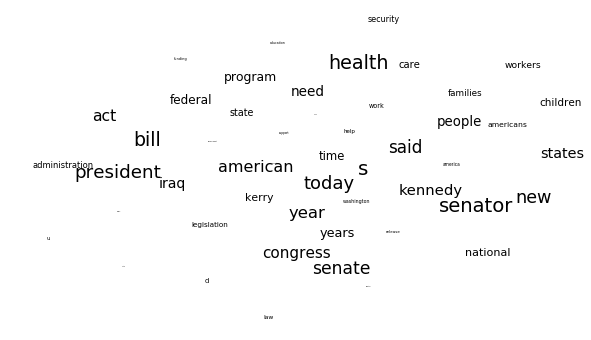

In [17]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(targetWords):
    ax.annotate(word, (tsneWords[:, 0][i],tsneWords[:, 1][i]), size =  20 * (numWords - i) / numWords)
plt.xticks(())
plt.yticks(())
plt.show()

My visualization above puts ``said`` next to ``congress`` and ``bill`` near ``act``. ``health`` is beside ``care`` and ``national`` abuts ``security``.

# Chinese examples

In [19]:
model=gensim.models.Word2Vec.load('../data/1992embeddings_hs_new3.sg')

## analogy

King+man-Queen? A few examples based on a corpus of Chinese news. 

First, location analogy: **province -> capital**

In [20]:
mm = model.most_similar(positive=[u'长沙',u'陕西'], negative=[u'湖南']) # Changsha + Shaanxi - Hunan
for m in mm:
    print(m[0],m[1])
    print("Xi'an")
    break

西安 0.36609965562820435
Xi'an


In [21]:
mm = model.most_similar(positive=[u'广州',u'湖北'], negative=[u'广东']) # Guangzhou + Hubei - Guangdong
for m in mm:
    print(m[0],m[1])
    print("Wuhan")
    break

武汉 0.3677000403404236
Wuhan


Second, location analogy: **country -> capital**

In [22]:
mm = model.most_similar(positive=[u'东京',u'美国'], negative=[u'日本']) # Tokyo + US - Japan
for m in mm:
    print(m[0],m[1])
    print("(Washington DC)")
    break

华盛顿 0.508813738822937
(Washington DC)


## similar words

In [23]:
word = u'社会主义'  #socialism
ss = model.similar_by_word(word,topn=10)
print("the most similar words to " + word + " is: ")
for s in ss:
    print(s[0])
print("")

the most similar words to 社会主义 is: 
特色
市场经济
理论
建设
改革开放
马克思主义
党
经济体制
基本路线
现代化



In [24]:
word = u'玉米'  # corn
ss = model.similar_by_word(word,topn=10)
print("the most similar words to " + word + " is: ")
for s in ss:
    print(s[0])
print("")

the most similar words to 玉米 is: 
小麦
水稻
作物
棉花
新品种
杂交
大豆
增产
栽培
农作物



## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Construct cells immediately below this that embed documents related to your final project using at least two different specification of `word2vec`, and visualize them each with two separate visualization layout specifications (e.g., TSNE, PCA). Then interrogate critical word vectors within your corpus in terms of the most similar words, analogies, and other additions and subtractions that reveal the structure of similarity and difference within your semantic space. What does this pattern reveal about the semantic organization of words in your corpora? Which estimation and visualization specification generate the most insight and appear the most robustly supported and why? 

<span style="color:red">***Stretch***: Explore different vector calculations beyond addition and subtraction, such as multiplication, division or some other function. What does this exploration reveal about the semantic structure of your corpus?

In [2]:
import pandas as pd
import re

In [3]:
# Load data
race_apw4 = pd.read_csv("../data/APW_race4.csv")
race_apw5 = pd.read_csv("../data/APW_race5.csv")

In [4]:
race_apw = race_apw4.append(race_apw5)
race_apw.reset_index(inplace=True)
race_apw.drop(['index'],axis=1, inplace=True)
race_apw.tail()

,category,url,title,text
2240,White (non-Hispanic),/islandora/object/apw%3A12346015?solr_nav%5Bid...,"Update letter 30, December 2015",DECEMBER 2015)\n\nKE\/IN FULLER/41648-424\nELK...
2241,White (non-Hispanic),/islandora/object/apw%3A12344778?solr_nav%5Bid...,Us against the world,"Us against the world\n\nDecember 9, 2010\n\nBy..."
2242,White (non-Hispanic),/islandora/object/apw%3A12356040?solr_nav%5Bid...,Utah society and corrections effectively teach...,Utah Society & Corrections Effectively Teach F...
2243,White (non-Hispanic),/islandora/object/apw%3A12352581?solr_nav%5Bid...,Utah's star chamber: The miscegenation of law ...,The Miscegenation of Law with Mormon Religious...
2244,White (non-Hispanic),/islandora/object/apw%3A12346594?solr_nav%5Bid...,"Vengeance is mine. Stay out of this, God!","""Vengeance is mine.""\n""Stay out of this, God!""..."


In [5]:
race_apw['text'] =  [re.sub(r'[\n]+',' ', str(x)) for x in race_apw['text']]
race_apw['text'] =  [re.sub(r'[//]+',' ', str(x)) for x in race_apw['text']]
race_apw['text'] =  [re.sub(r'[\\]','', str(x)) for x in race_apw['text']]
race_apw['text'] =  [re.sub(r'[^a-zA-Z0-9 \']',' ', str(x)) for x in race_apw['text']]

In [6]:
race_apw.shape

(2245, 4)

In [7]:
race_apw.groupby('category').count()

,url,title,text
category,,,
African American,737,737,737
Asian American,18,18,18
Black/African American,1,1,1
Latina/o / Hispanic,147,147,147
Multiracial,290,290,290
Native American,87,87,87
No information,98,98,98
Other,22,22,22
White (non-Hispanic),845,845,845


In [8]:
# rename category bc that is not relevant for topic modeling - current category variable refers to race of the author
race_apw = race_apw.rename(columns={'category':'race'})

In [9]:
#Apply our functions, notice each row is a list of lists now
race_apw['tokenized_sents'] = race_apw['text'].apply(lambda x: [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x)])
race_apw['normalized_sents'] = race_apw['tokenized_sents'].apply(lambda x: [lucem_illud_2020.normalizeTokens(s, lemma=False) for s in x])

race_apw[:100:10]


,race,url,title,text,tokenized_sents,normalized_sents
0,African American,/islandora/object/apw%3A12345532?solr_nav%5Bid...,#Incarcerated lives matter,Incarcerated Lives Matter By Lacino Hamilton...,"[[Incarcerated, Lives, Matter, By, Lacino, Ham...","[[incarcerated, lives, matter, lacino, hamilto..."
10,African American,/islandora/object/apw%3A288?solr_nav%5Bid%5D=0...,A brief summary of the demise of the Colorado ...,A BRIEF SUMMARY OF THE DEMISE OF THE COLORADO ...,"[[A, BRIEF, SUMMARY, OF, THE, DEMISE, OF, THE,...","[[brief, summary, demise, colorado, dept, corr..."
20,African American,/islandora/object/apw%3A12346902?solr_nav%5Bid...,A letter to law-enforcement executives,A Letter to Law Enforcement Executives My name...,"[[A, Letter, to, Law, Enforcement, Executives]...","[[letter, law, enforcement, executives], [will..."
30,African American,/islandora/object/apw%3A12357874?solr_nav%5Bid...,A proposal: The death penalty,A proposal The Death Penalty Contract Who I...,"[[A, proposal, The, Death, Penalty, Contract],...","[[proposal, death, penalty, contract], [], [in..."
40,African American,/islandora/object/apw%3A12348030?solr_nav%5Bid...,Administrative prison officials and authority,Administrative Prison Officials and Authority...,"[[Administrative, Prison, Officials, and, Auth...","[[administrative, prison, officials, authority..."
50,African American,/islandora/object/apw%3A12345559?solr_nav%5Bid...,"An open letter to prisoner advocacy groups, an...",An Open Letter To Prisoner Advocacy Groups And...,"[[An, Open, Letter, To, Prisoner, Advocacy, Gr...","[[open, letter, prisoner, advocacy, groups, pe..."
60,African American,/islandora/object/apw%3A12355935?solr_nav%5Bid...,Aramark is pimping the GDOC,Aramark is Pimping the GDOC Greetings World I...,"[[Aramark, is, Pimping, the, GDOC, Greetings, ...","[[aramark, pimping, gdoc, greetings, world], [..."
70,African American,/islandora/object/apw%3A12346728?solr_nav%5Bid...,At the time my friend and brotha,No Title 05 27 2015 At the time my friend an...,"[[No], [Title, 05, 27, 2015], [At, the, time, ...","[[], [title], [time, friend, brotha, ask, writ..."
80,African American,/islandora/object/apw%3A12357643?solr_nav%5Bid...,Before I as in Charles,NO TITLE 4 6 2019 Before I as in Charles Antho...,"[[NO, TITLE, 4, 6, 2019, Before, I, as, in, Ch...","[[title, charles, anthony, paschal, jr, think,..."
90,African American,/islandora/object/apw%3A12353053?solr_nav%5Bid...,Benevolence,Benevolence As I sit here contemplating what...,"[[Benevolence], [As, I, sit, here, contemplati...","[[benevolence], [sit, contemplating, like, sha..."


In [10]:
#class gensim.models.word2vec.Word2Vec(sentences=None, corpus_file=None, size=100, alpha=0.025, window=5, min_count=5, max_vocab_size=None, sample=0.001, seed=1, workers=3, min_alpha=0.0001, sg=0, hs=0, negative=5, ns_exponent=0.75, cbow_mean=1, hashfxn=<built-in function hash>, iter=5, null_word=0, trim_rule=None, sorted_vocab=1, batch_words=10000, compute_loss=False, callbacks=(), max_final_vocab=None)



In [11]:
# First specification of word2vec - using default parameters
apw_W2V_1 = gensim.models.word2vec.Word2Vec(race_apw['normalized_sents'].sum())

In [12]:
apw_W2V_1.save("apw_W2V_1")

In [13]:
# Second specification of word2vec - changing min_count to 10 (default is 5)
apw_W2V_2 = gensim.models.word2vec.Word2Vec(race_apw['normalized_sents'].sum(), min_count=10)

In [14]:
apw_W2V_2.save("apw_W2V_2")

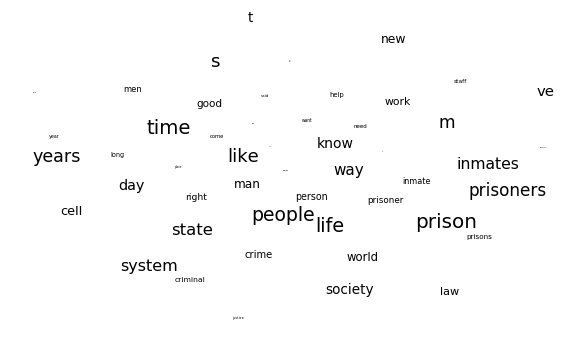

In [15]:
# Visualization #1 of first word2vec
numWords = 50
targetWords = apw_W2V_1.wv.index2word[:numWords]

wordsSubMatrix = []
for word in targetWords:
    wordsSubMatrix.append(apw_W2V_1[word])
wordsSubMatrix = np.array(wordsSubMatrix)
wordsSubMatrix

pcaWords = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_data = pcaWords.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWords = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_data)

fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(targetWords):
    ax.annotate(word, (tsneWords[:, 0][i],tsneWords[:, 1][i]), size =  20 * (numWords - i) / numWords)
plt.xticks(())
plt.yticks(())
plt.show()

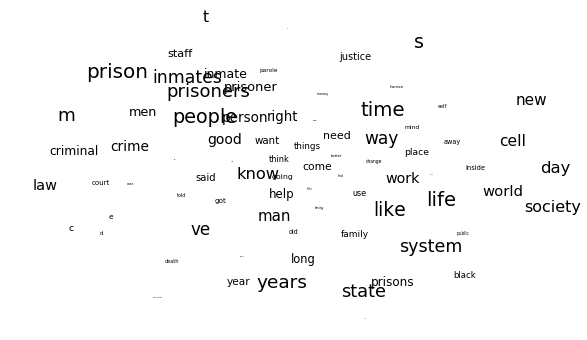

In [16]:
# Visualization #2 of first word2vec
numWords = 80
targetWords = apw_W2V_1.wv.index2word[:numWords]

wordsSubMatrix = []
for word in targetWords:
    wordsSubMatrix.append(apw_W2V_1[word])
wordsSubMatrix = np.array(wordsSubMatrix)
wordsSubMatrix

pcaWords = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_data = pcaWords.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWords = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_data)

fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(targetWords):
    ax.annotate(word, (tsneWords[:, 0][i],tsneWords[:, 1][i]), size =  20 * (numWords - i) / numWords)
plt.xticks(())
plt.yticks(())
plt.show()

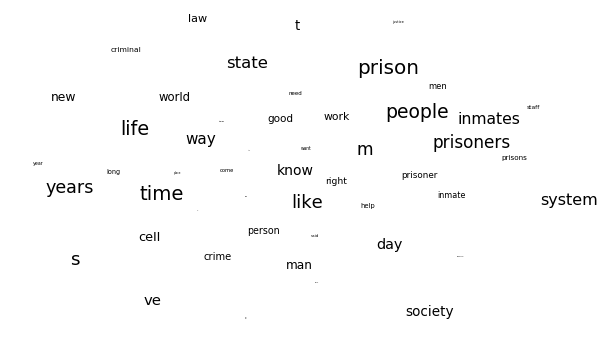

In [17]:
# Visualization #1 of second word2vec
numWords = 50
targetWords = apw_W2V_2.wv.index2word[:numWords]

wordsSubMatrix = []
for word in targetWords:
    wordsSubMatrix.append(apw_W2V_2[word])
wordsSubMatrix = np.array(wordsSubMatrix)
wordsSubMatrix

pcaWords = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_data = pcaWords.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWords = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_data)

fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(targetWords):
    ax.annotate(word, (tsneWords[:, 0][i],tsneWords[:, 1][i]), size =  20 * (numWords - i) / numWords)
plt.xticks(())
plt.yticks(())
plt.show()

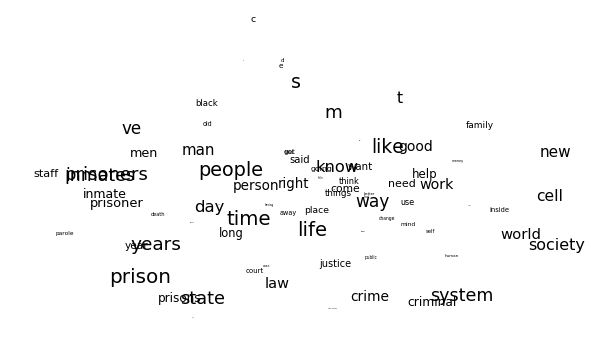

In [18]:
# Visualization #2 of second word2vec
numWords = 80
targetWords = apw_W2V_2.wv.index2word[:numWords]

wordsSubMatrix = []
for word in targetWords:
    wordsSubMatrix.append(apw_W2V_2[word])
wordsSubMatrix = np.array(wordsSubMatrix)
wordsSubMatrix

pcaWords = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_data = pcaWords.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWords = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_data)

fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(targetWords):
    ax.annotate(word, (tsneWords[:, 0][i],tsneWords[:, 1][i]), size =  20 * (numWords - i) / numWords)
plt.xticks(())
plt.yticks(())
plt.show()

In [19]:
apw_W2V_1.most_similar('prisoner')

[('inmate', 0.7969391942024231),
 ('prisoners', 0.6606587171554565),
 ('acc', 0.6218667030334473),
 ('institutional', 0.6116708517074585),
 ('substantial', 0.6110206842422485),
 ('administrative', 0.5988882780075073),
 ('tdej', 0.5923426747322083),
 ('leeway', 0.5919250249862671),
 ('detainees', 0.5912163257598877),
 ('individual', 0.5817379951477051)]

In [20]:
apw_W2V_2.most_similar('prisoner')

[('inmate', 0.7662435173988342),
 ('prisoners', 0.6524549722671509),
 ('acc', 0.6071312427520752),
 ('violations', 0.5988945364952087),
 ('administrative', 0.5743104815483093),
 ('detainees', 0.5728878974914551),
 ('individual', 0.5671113133430481),
 ('substantial', 0.566632091999054),
 ('institutional', 0.5643807649612427),
 ('general', 0.5637664198875427)]

In [21]:
apw_W2V_1.most_similar('justice')

[('judicial', 0.8038873672485352),
 ('penal', 0.7737307548522949),
 ('endorsing', 0.7491419315338135),
 ('caste', 0.727123498916626),
 ('acti', 0.724640965461731),
 ('belief', 0.7220257520675659),
 ('flawed', 0.7212229371070862),
 ('injustice', 0.7108044624328613),
 ('corrupt', 0.7090751528739929),
 ('appellants', 0.7013465166091919)]

In [22]:
apw_W2V_2.most_similar('justice')

[('judicial', 0.8178101778030396),
 ('penal', 0.7791192531585693),
 ('injustice', 0.741045355796814),
 ('belief', 0.7138717174530029),
 ('flawed', 0.7081013917922974),
 ('corrupt', 0.7013843059539795),
 ('caste', 0.6735618710517883),
 ('history', 0.6643149852752686),
 ('enterprises', 0.6430761814117432),
 ('immune', 0.6352040767669678)]

In [23]:
apw_W2V_1.most_similar('mental')

[('regiment', 0.8185186982154846),
 ('care', 0.7953360080718994),
 ('hazard', 0.7872554063796997),
 ('issues', 0.7837108373641968),
 ('chronic', 0.7702576518058777),
 ('wellness', 0.7673691511154175),
 ('physical', 0.7661521434783936),
 ('psychological', 0.7638987898826599),
 ('disorder', 0.7475506067276001),
 ('deteriorating', 0.7437999844551086)]

In [24]:
apw_W2V_1.most_similar('guard')

[('riot', 0.8058919906616211),
 ('guards', 0.7871479988098145),
 ('handcuffed', 0.7817831039428711),
 ('pod', 0.7783818244934082),
 ('dorm', 0.7741938233375549),
 ('beat', 0.7696455717086792),
 ('searched', 0.7685626745223999),
 ('camera', 0.7683979272842407),
 ('yards', 0.7675435543060303),
 ('walled', 0.7637581825256348)]

In [25]:
apw_W2V_2.most_similar('guard')

[('dorm', 0.7913436889648438),
 ('guards', 0.7843425273895264),
 ('searched', 0.7777291536331177),
 ('handcuffed', 0.7719371914863586),
 ('riot', 0.7699316740036011),
 ('camera', 0.7683553695678711),
 ('pod', 0.7596085667610168),
 ('yards', 0.7553814649581909),
 ('spray', 0.7528160214424133),
 ('wing', 0.7515064477920532)]

In [26]:
apw_W2V_1.most_similar('system')

[('systems', 0.817874014377594),
 ('restorative', 0.7278878688812256),
 ('institutions', 0.70144122838974),
 ('reform', 0.6672044992446899),
 ('industry', 0.660880982875824),
 ('industrial', 0.6581858396530151),
 ('complex', 0.6543277502059937),
 ('vigilante', 0.6432106494903564),
 ('politics', 0.6398047208786011),
 ('vera', 0.6322187185287476)]

In [27]:
apw_W2V_2.most_similar('system')

[('systems', 0.7975946664810181),
 ('restorative', 0.716127336025238),
 ('institutions', 0.6638248562812805),
 ('vigilante', 0.6611658930778503),
 ('complex', 0.6528669595718384),
 ('industrial', 0.6480128169059753),
 ('industry', 0.6458531618118286),
 ('reform', 0.6232144236564636),
 ('politics', 0.6211772561073303),
 ('industries', 0.61347496509552)]

In [28]:
apw_W2V_1.most_similar('black')

[('white', 0.9033539295196533),
 ('african', 0.8120899200439453),
 ('panthers', 0.7985522150993347),
 ('color', 0.7983527183532715),
 ('males', 0.7743300199508667),
 ('male', 0.7613990902900696),
 ('hispanic', 0.7467320561408997),
 ('gay', 0.7433223128318787),
 ('blacks', 0.7420752048492432),
 ('whites', 0.7403624057769775)]

In [29]:
apw_W2V_2.most_similar('black')

[('white', 0.8913878202438354),
 ('color', 0.804344654083252),
 ('african', 0.7929095029830933),
 ('blacks', 0.7782496213912964),
 ('panthers', 0.7739883065223694),
 ('whites', 0.7739009857177734),
 ('panther', 0.7684926390647888),
 ('male', 0.7676072716712952),
 ('males', 0.7672461271286011),
 ('native', 0.7613214254379272)]

In [30]:
apw_W2V_1.most_similar('god')

[('lord', 0.8659883141517639),
 ('christ', 0.8513238430023193),
 ('faith', 0.8356087803840637),
 ('jesus', 0.835330605506897),
 ('forgiveness', 0.8283381462097168),
 ('bless', 0.8034093379974365),
 ('pray', 0.7996017932891846),
 ('mercy', 0.7909907102584839),
 ('love', 0.7907045483589172),
 ('thank', 0.7887609601020813)]

In [31]:
apw_W2V_2.most_similar('god')

[('lord', 0.8631371259689331),
 ('jesus', 0.8499557971954346),
 ('christ', 0.8439366817474365),
 ('faith', 0.824408769607544),
 ('mercy', 0.8124991059303284),
 ('forgiveness', 0.7969545125961304),
 ('pray', 0.7803810834884644),
 ('bless', 0.7754937410354614),
 ('christian', 0.7695136070251465),
 ('christians', 0.7546066045761108)]

In [32]:
apw_W2V_1.most_similar('condition')

[('damage', 0.887603759765625),
 ('effects', 0.8800852298736572),
 ('suffer', 0.8750029802322388),
 ('torment', 0.8747891187667847),
 ('stimulation', 0.8732123374938965),
 ('distress', 0.8726348876953125),
 ('affects', 0.8677936792373657),
 ('debilitating', 0.8673851490020752),
 ('bondage', 0.8664177656173706),
 ('leads', 0.8663268089294434)]

In [33]:
apw_W2V_1.most_similar('cell')

[('cells', 0.8172388672828674),
 ('strip', 0.7794221639633179),
 ('revolving', 0.7765234708786011),
 ('block', 0.7716909646987915),
 ('doors', 0.7624469995498657),
 ('occupancy', 0.7567726373672485),
 ('door', 0.7528683543205261),
 ('phones', 0.7477419376373291),
 ('van', 0.7435381412506104),
 ('yard', 0.7408967018127441)]

In [34]:
apw_W2V_1.most_similar('society')

[('community', 0.69497150182724),
 ('productive', 0.6947165131568909),
 ('incompatible', 0.681228756904602),
 ('civilized', 0.6810963153839111),
 ('communities', 0.6718169450759888),
 ('citizen', 0.6684622764587402),
 ('transition', 0.6479002833366394),
 ('remain', 0.6457526683807373),
 ('societies', 0.6389933824539185),
 ('larger', 0.6329435110092163)]

In [35]:
apw_W2V_1.doesnt_match(['criminal', 'law', 'man', 'prisoner', 'God'])


'man'

In [36]:
apw_W2V_2.doesnt_match(['criminal', 'law', 'man', 'prisoner', 'God'])


'criminal'

In [37]:
apw_W2V_1.most_similar(positive=['inmate', 'white'], negative = ['prison'])

[('supremacists', 0.6737546920776367),
 ('assaulted', 0.670194685459137),
 ('female', 0.6609503030776978),
 ('brown', 0.637101948261261),
 ('collar', 0.6196604371070862),
 ('cos', 0.6126606464385986),
 ('male', 0.6080741882324219),
 ('grouped', 0.6025872230529785),
 ('hispanic', 0.597950279712677),
 ('panthers', 0.594508171081543)]

In [38]:
apw_W2V_1.most_similar_cosmul(positive=['inmate', 'white'], negative = ['prison'])


[('assaulted', 1.0671627521514893),
 ('supremacists', 1.0536900758743286),
 ('brown', 1.0405136346817017),
 ('female', 1.0297574996948242),
 ('lowe', 1.017569899559021),
 ('cos', 1.0076411962509155),
 ('co', 0.9924341440200806),
 ('raped', 0.9904932379722595),
 ('guard', 0.9893430471420288),
 ('grouped', 0.9815769791603088)]

In [39]:
apw_W2V_1.most_similar('inmate')

[('prisoner', 0.7969391942024231),
 ('inmates', 0.6853972673416138),
 ('custody', 0.6328352689743042),
 ('unit', 0.6252913475036621),
 ('transfer', 0.622056245803833),
 ('shu', 0.6211308240890503),
 ('tdcj', 0.6174081563949585),
 ('segregation', 0.6002366542816162),
 ('member', 0.5989720225334167),
 ('security', 0.5960394144058228)]

In [40]:
apw_W2V_1.most_similar('mental')

[('regiment', 0.8185186982154846),
 ('care', 0.7953360080718994),
 ('hazard', 0.7872554063796997),
 ('issues', 0.7837108373641968),
 ('chronic', 0.7702576518058777),
 ('wellness', 0.7673691511154175),
 ('physical', 0.7661521434783936),
 ('psychological', 0.7638987898826599),
 ('disorder', 0.7475506067276001),
 ('deteriorating', 0.7437999844551086)]

In [41]:
apw_W2V_1.most_similar(positive=['mental','man'], negative=['woman'])

[('condition', 0.6823424100875854),
 ('regiment', 0.6634202599525452),
 ('psychological', 0.6580836772918701),
 ('physical', 0.6481877565383911),
 ('conditions', 0.6456234455108643),
 ('issues', 0.6424649953842163),
 ('brain', 0.6322645545005798),
 ('care', 0.624115526676178),
 ('treatment', 0.6197677254676819),
 ('disease', 0.6136626601219177)]

In [42]:
apw_W2V_1.most_similar(positive=['mental','woman'], negative=['man'])

[('occuring', 0.6825678944587708),
 ('suffered', 0.6799066066741943),
 ('regiment', 0.6791059970855713),
 ('care', 0.6775601506233215),
 ('hazard', 0.6748663187026978),
 ('organisms', 0.6640195846557617),
 ('injuries', 0.6605024933815002),
 ('endangered', 0.6522091627120972),
 ('chronic', 0.6504207849502563),
 ('wellness', 0.6491878628730774)]

In [100]:
apw_W2V_1.most_similar(positive=['inmate','man'], negative=['woman'])

[('prisoner', 0.7946914434432983),
 ('inmates', 0.6547897458076477),
 ('prisoners', 0.5995354652404785),
 ('administration', 0.5299344062805176),
 ('person', 0.5065556764602661),
 ('general', 0.5045567154884338),
 ('administrative', 0.504412055015564),
 ('population', 0.5025872588157654),
 ('security', 0.49776414036750793),
 ('administrators', 0.4927966296672821)]

In [99]:
apw_W2V_1.most_similar(positive=['inmate','woman'], negative=['man'])

[('assaulted', 0.6824465990066528),
 ('threatened', 0.6748267412185669),
 ('reported', 0.6662893295288086),
 ('visitation', 0.6632728576660156),
 ('twice', 0.6393214464187622),
 ('shu', 0.6340023279190063),
 ('female', 0.6337714195251465),
 ('fired', 0.6329180002212524),
 ('injured', 0.6327077746391296),
 ('assaulting', 0.6307038068771362)]

In [112]:
apw_W2V_1.most_similar(positive=['inmate','black'], negative=['white'])

[('prisoner', 0.7581943273544312),
 ('inmates', 0.6337708830833435),
 ('general', 0.6087144613265991),
 ('accommodates', 0.5755468606948853),
 ('prisoners', 0.5545321702957153),
 ('leeway', 0.5392181873321533),
 ('transfer', 0.5382838249206543),
 ('eligible', 0.5359633564949036),
 ('supervise', 0.53499436378479),
 ('reason', 0.5315895676612854)]

In [101]:
apw_W2V_1.most_similar(positive=['inmate','white'], negative=['black'])

[('prisoner', 0.7060920000076294),
 ('placed', 0.6627845764160156),
 ('officer', 0.6242533922195435),
 ('assigned', 0.623913049697876),
 ('seg', 0.6225357055664062),
 ('unit', 0.6204003691673279),
 ('protective', 0.6175668835639954),
 ('threatened', 0.6173121333122253),
 ('inmates', 0.6165086030960083),
 ('segregation', 0.6074063777923584)]

In [113]:
apw_W2V_1.most_similar('guard')

[('riot', 0.809485673904419),
 ('guards', 0.7995100617408752),
 ('dorm', 0.7906913757324219),
 ('pod', 0.7802724838256836),
 ('camera', 0.7749552726745605),
 ('handcuffed', 0.7597157955169678),
 ('beat', 0.7543115019798279),
 ('cellmate', 0.7529596090316772),
 ('walked', 0.7492508888244629),
 ('wing', 0.7491636276245117)]

In [110]:
apw_W2V_1.most_similar(positive=['guard','white'], negative=['black'])

[('pod', 0.77192223072052),
 ('riot', 0.7604727745056152),
 ('dorm', 0.7497227191925049),
 ('camera', 0.7473586201667786),
 ('guards', 0.7395210266113281),
 ('handcuffed', 0.7384616732597351),
 ('handcuffs', 0.727137565612793),
 ('walked', 0.7259031534194946),
 ('ran', 0.7224562168121338),
 ('officer', 0.7178524732589722)]

In [109]:
apw_W2V_1.most_similar(positive=['guard','black'], negative=['white'])

[('guards', 0.7485491037368774),
 ('riot', 0.7407035827636719),
 ('tails', 0.7149500846862793),
 ('dorm', 0.7133832573890686),
 ('compound', 0.7120804786682129),
 ('gate', 0.7081394791603088),
 ('corral', 0.6973448991775513),
 ('gates', 0.6919100880622864),
 ('beat', 0.6912224292755127),
 ('attacked', 0.6892563104629517)]

## Takeaways

The first word2vec specification (using the default parameter of min_count = 5) and second visualization (80 words) seem to generate the most insight and appear to be the most robustly supported. The other visualizations are too sparse, or have too many overlapping words to be useful. This suggests that min_count = 10 might be too restrictive for this corpus. That suggests there is enough variation in this corpus that requiring words to show up at least 10 times might reduce the insight we can get.

For example, in the first visualization of the first specification, we see the word "society" surrrounded by "world", "new", and "self". In the first visualization of the second specification, the word "society" isn't surrounded by anything. However, in the second visualization of the second specification, we see some of the same patterns emerge - so if I use a more restrictive min_count for word2vec, I need to show more words to gain the same insight.

The other take aways that I think are interesting is looking at words most similar to "inmate" and "guard" - first by themselves, and then by gender / race. 

Let's first consider "inmate" - on it's own, the words that are most similar to inmate look like the words that are similar to "inmate" and "man", subtracting "woman". We see words like "prisoner", "transfer", "administration" - fairly bureaucratic words. However, when I look at "inmate" plus "woman" and subtract "man", the words are very different  - e.g. "assaulted", "threatened", "reported", "injured". This could imply a few different interpretations, but it certainly suggests that the difference between "man" and "woman" shift the word vector from more bureaucratic words to more violent words.

We see something similar happen when looking at "guard" - by itself, and then by race. Words similar to "guard" are "riot", "handcuffed", "cell", "beat", "wing" - some words implying violence, others related to parts of the prison.

However, when we negate "black" and add "white", we see some of the violent words go away. When we instead add "white" and negate "black", we see words like "beat", "attacked" and "corral" - more active, more violent words.

Taken together, this exercise suggests that the word2vec could be useful in understanding the different experiences of men and women, or individuals of different races, inside the carceral system.



# Doc2Vec

Instead of just looking at just how words embed within in the space, we can look at how the different documents relate to each other within the space. First lets load our data--abstracts of most U.S. physics papers from the 1950s.

In [114]:
apsDF = pandas.read_csv('../data/APSabstracts1950s.csv', index_col = 0)
apsDF[:10]

,copyrightYear,doi,abstract
0,1950,10.1103/RevModPhys.22.221,A summarizing account is given of the research...
1,1951,10.1103/RevModPhys.23.147,New tables of coulomb functions are presented ...
2,1951,10.1103/RevModPhys.23.185,Ionization by electron impact in diatomic gase...
3,1951,10.1103/RevModPhys.23.203,It is shown that the conductivity in the ohmic...
4,1951,10.1103/RevModPhys.23.21,The factorization method is an operational pro...
5,1951,10.1103/RevModPhys.23.311,A brief account is given of Dyson's proof of t...
6,1951,10.1103/RevModPhys.23.315,A systematics is given of all transitions for ...
7,1951,10.1103/RevModPhys.23.322,A systematics of the -transitions of even A nu...
8,1951,10.1103/RevModPhys.23.328,The available experiments on the absorption sp...
9,1952,10.1103/RevModPhys.24.108,The classical theory of the dynamics of viscou...


We will load these as documents into Word2Vec, but first we need to normalize and pick some tags.

In [115]:
keywords = ['photomagnetoelectric', 'quantum', 'boltzmann', 'proton', 'positron', 'feynman', 'classical', 'relativity']

In [116]:
apsDF['tokenized_words'] = apsDF['abstract'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
apsDF['normalized_words'] = apsDF['tokenized_words'].apply(lambda x: lucem_illud_2020.normalizeTokens(x, lemma=False))

In [140]:
taggedDocs = []
for index, row in apsDF.iterrows():
    #Just doing a simple keyword assignment
    docKeywords = [s for s in keywords if s in row['normalized_words']]
    docKeywords.append(row['copyrightYear'])
    docKeywords.append(row['doi']) #This lets us extract individual documnets since doi's are unique
    taggedDocs.append(gensim.models.doc2vec.LabeledSentence(words = row['normalized_words'], tags = docKeywords))
apsDF['TaggedAbstracts'] = taggedDocs


In [139]:
apsDF['TaggedAbstracts'][7]

LabeledSentence(words=['systematics', '-transitions', 'nuclei', 'given', 'interpretation', 'character', 'transitions', 'terms', 'nuclear', 'shell', 'structure', 'achieved', 'hypothesis', 'odd', 'nucleon', 'groups', 'structure', 'odd', 'nuclei', 'simple', 'coupling', 'rule', 'neutron', 'proton', 'groups', 'odd', 'odd', 'nuclei'], tags=['proton', 1951, '10.1103/RevModPhys.23.322'])

Now we can train a Doc2Vec model:

In [118]:
apsD2V = gensim.models.doc2vec.Doc2Vec(apsDF['TaggedAbstracts'], size = 100) #Limiting to 100 dimensions

/Users/daminisharma/miniconda3/lib/python3.7/site-packages/gensim/models/doc2vec.py:574: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


We can get vectors for the tags/documents, just as we did with words. Documents are actually the centroids (high dimensional average points) of their words. 

In [119]:
apsD2V.docvecs[1952]

array([-1.1218071 ,  0.24906208,  1.1116419 ,  0.537136  ,  0.41375673,
        1.7110978 , -0.8866813 ,  0.08380027, -1.2415401 ,  1.3970467 ,
        0.08837593, -1.4165008 ,  0.7797958 ,  0.20638104,  0.04233992,
       -0.86864424,  0.90230024, -0.2286727 ,  0.36636162,  1.1487508 ,
       -0.10996401, -2.2023613 , -0.6866346 , -0.77936405, -0.12264281,
       -0.8259131 ,  1.313342  ,  0.193999  , -0.84814537,  0.17355983,
       -1.5398303 ,  0.65145844, -0.5249637 , -0.8892431 ,  0.2727851 ,
        0.9084619 , -0.36640972,  2.0301342 , -0.6179794 ,  1.5398227 ,
       -0.48515263, -0.1109917 ,  1.9385792 , -0.6607476 ,  0.01354031,
       -1.6177515 , -1.1317251 ,  0.8167437 , -1.2298923 ,  0.10536442,
        0.30457526, -0.7191131 , -0.5793758 ,  1.1489043 , -0.43833357,
        0.35591444, -1.7192392 ,  1.1624556 , -0.05984561,  0.05393806,
       -0.37108466, -0.97350764, -0.3442887 ,  0.8690871 , -1.6457134 ,
        0.08221076, -1.7500502 , -0.9541105 ,  1.1428746 ,  1.51

The words can still be accessed in the same way:

In [120]:
apsD2V['atom']

array([-0.56725377,  0.70548916,  0.9087707 ,  0.11991809,  0.65799654,
        0.56241757, -0.05327993,  0.4102768 , -0.7781422 ,  0.26079983,
        0.12894326, -0.31040218, -0.6583636 ,  0.79012966, -0.15388612,
        0.4279485 ,  0.44086727,  0.13809507,  0.18258013,  1.0663246 ,
        0.31375143, -0.2730968 , -0.346434  ,  0.2429235 , -0.32698917,
        0.00742615, -0.19079292,  0.8980516 , -0.3497068 ,  0.37925366,
       -0.03338967,  0.10668152, -0.32486597, -0.11559654, -0.50348663,
        0.53171825, -0.47634092,  0.6560487 , -0.07956265,  0.82039946,
       -0.13937683, -0.3775762 ,  0.02342525, -0.11993574, -1.1131402 ,
        1.1957338 ,  0.11912686,  0.68463653, -0.35285503,  0.40220186,
        0.36986595,  0.05940435,  0.33466196,  1.2502171 ,  0.2162332 ,
        0.4776445 ,  0.7198731 ,  0.59546   , -0.34656924,  0.6647752 ,
       -0.18442126, -0.9088316 ,  0.30915838,  0.65291464,  0.24891014,
        0.617283  , -0.08939948, -0.8605837 ,  0.11620136, -0.06

We can still use the ``most_similar`` command to perform simple semantic equations:

In [32]:
apsD2V.most_similar(positive = ['atom','electrons'], negative = ['electron'], topn = 1)

[('atoms', 0.808495819568634)]

This is interesting. **Electron** is to **electrons** as **atom** is to **atoms**. Another way to understand this, developed below is: **electrons - electron** induces a singular to plural dimension, so when we subtract **electron** from **atom** and add **electrons**, we get **atoms**! 

In [33]:
apsD2V.most_similar(positive = ['einstein','law'], negative = ['equation'], topn = 1)

[('resemblance', 0.9027340412139893)]

In other words **Einstein** minus **equation** plus **law** equals **Meissner**--Walthur Meissner studied mechanical engineering and physics ... and was more likely to produce a "law" than a "equation", like the Meissner effect, the damping of the magnetic field in superconductors. If we built our word-embedding with a bigger corpus like the entire arXiv, a massive repository of physics preprints, we would see many more such relationships like **gravity - Newton + Einstein = relativity**.

We can also compute all of these *by hand*--explicitly wth vector algebra: 

In [34]:
sklearn.metrics.pairwise.cosine_similarity(apsD2V['electron'].reshape(1,-1), apsD2V['positron'].reshape(1,-1))
#We reorient the vectors with .reshape(1, -1) so that they can be computed without a warning in sklearn

array([[0.63588536]], dtype=float32)

In the doc2vec model, the documents have vectors just as the words do, so that we can compare documents with each other and also with words (similar to how a search engine locates a webpage with a query). First, we will calculate the distance between a word and documents in the dataset:

In [35]:
apsD2V.docvecs.most_similar([ apsD2V['electron'] ], topn=5 )

[('10.1103/PhysRev.113.479', 0.6609346866607666),
 ('10.1103/PhysRev.104.1528', 0.6466891169548035),
 ('10.1103/PhysRev.110.857', 0.6089353561401367),
 ('10.1103/PhysRev.106.191', 0.6088852882385254),
 ('10.1103/PhysRev.100.1646', 0.6056019067764282)]

If we search for the first of these on the web (these are doi codes), we find the following...a pretty good match:

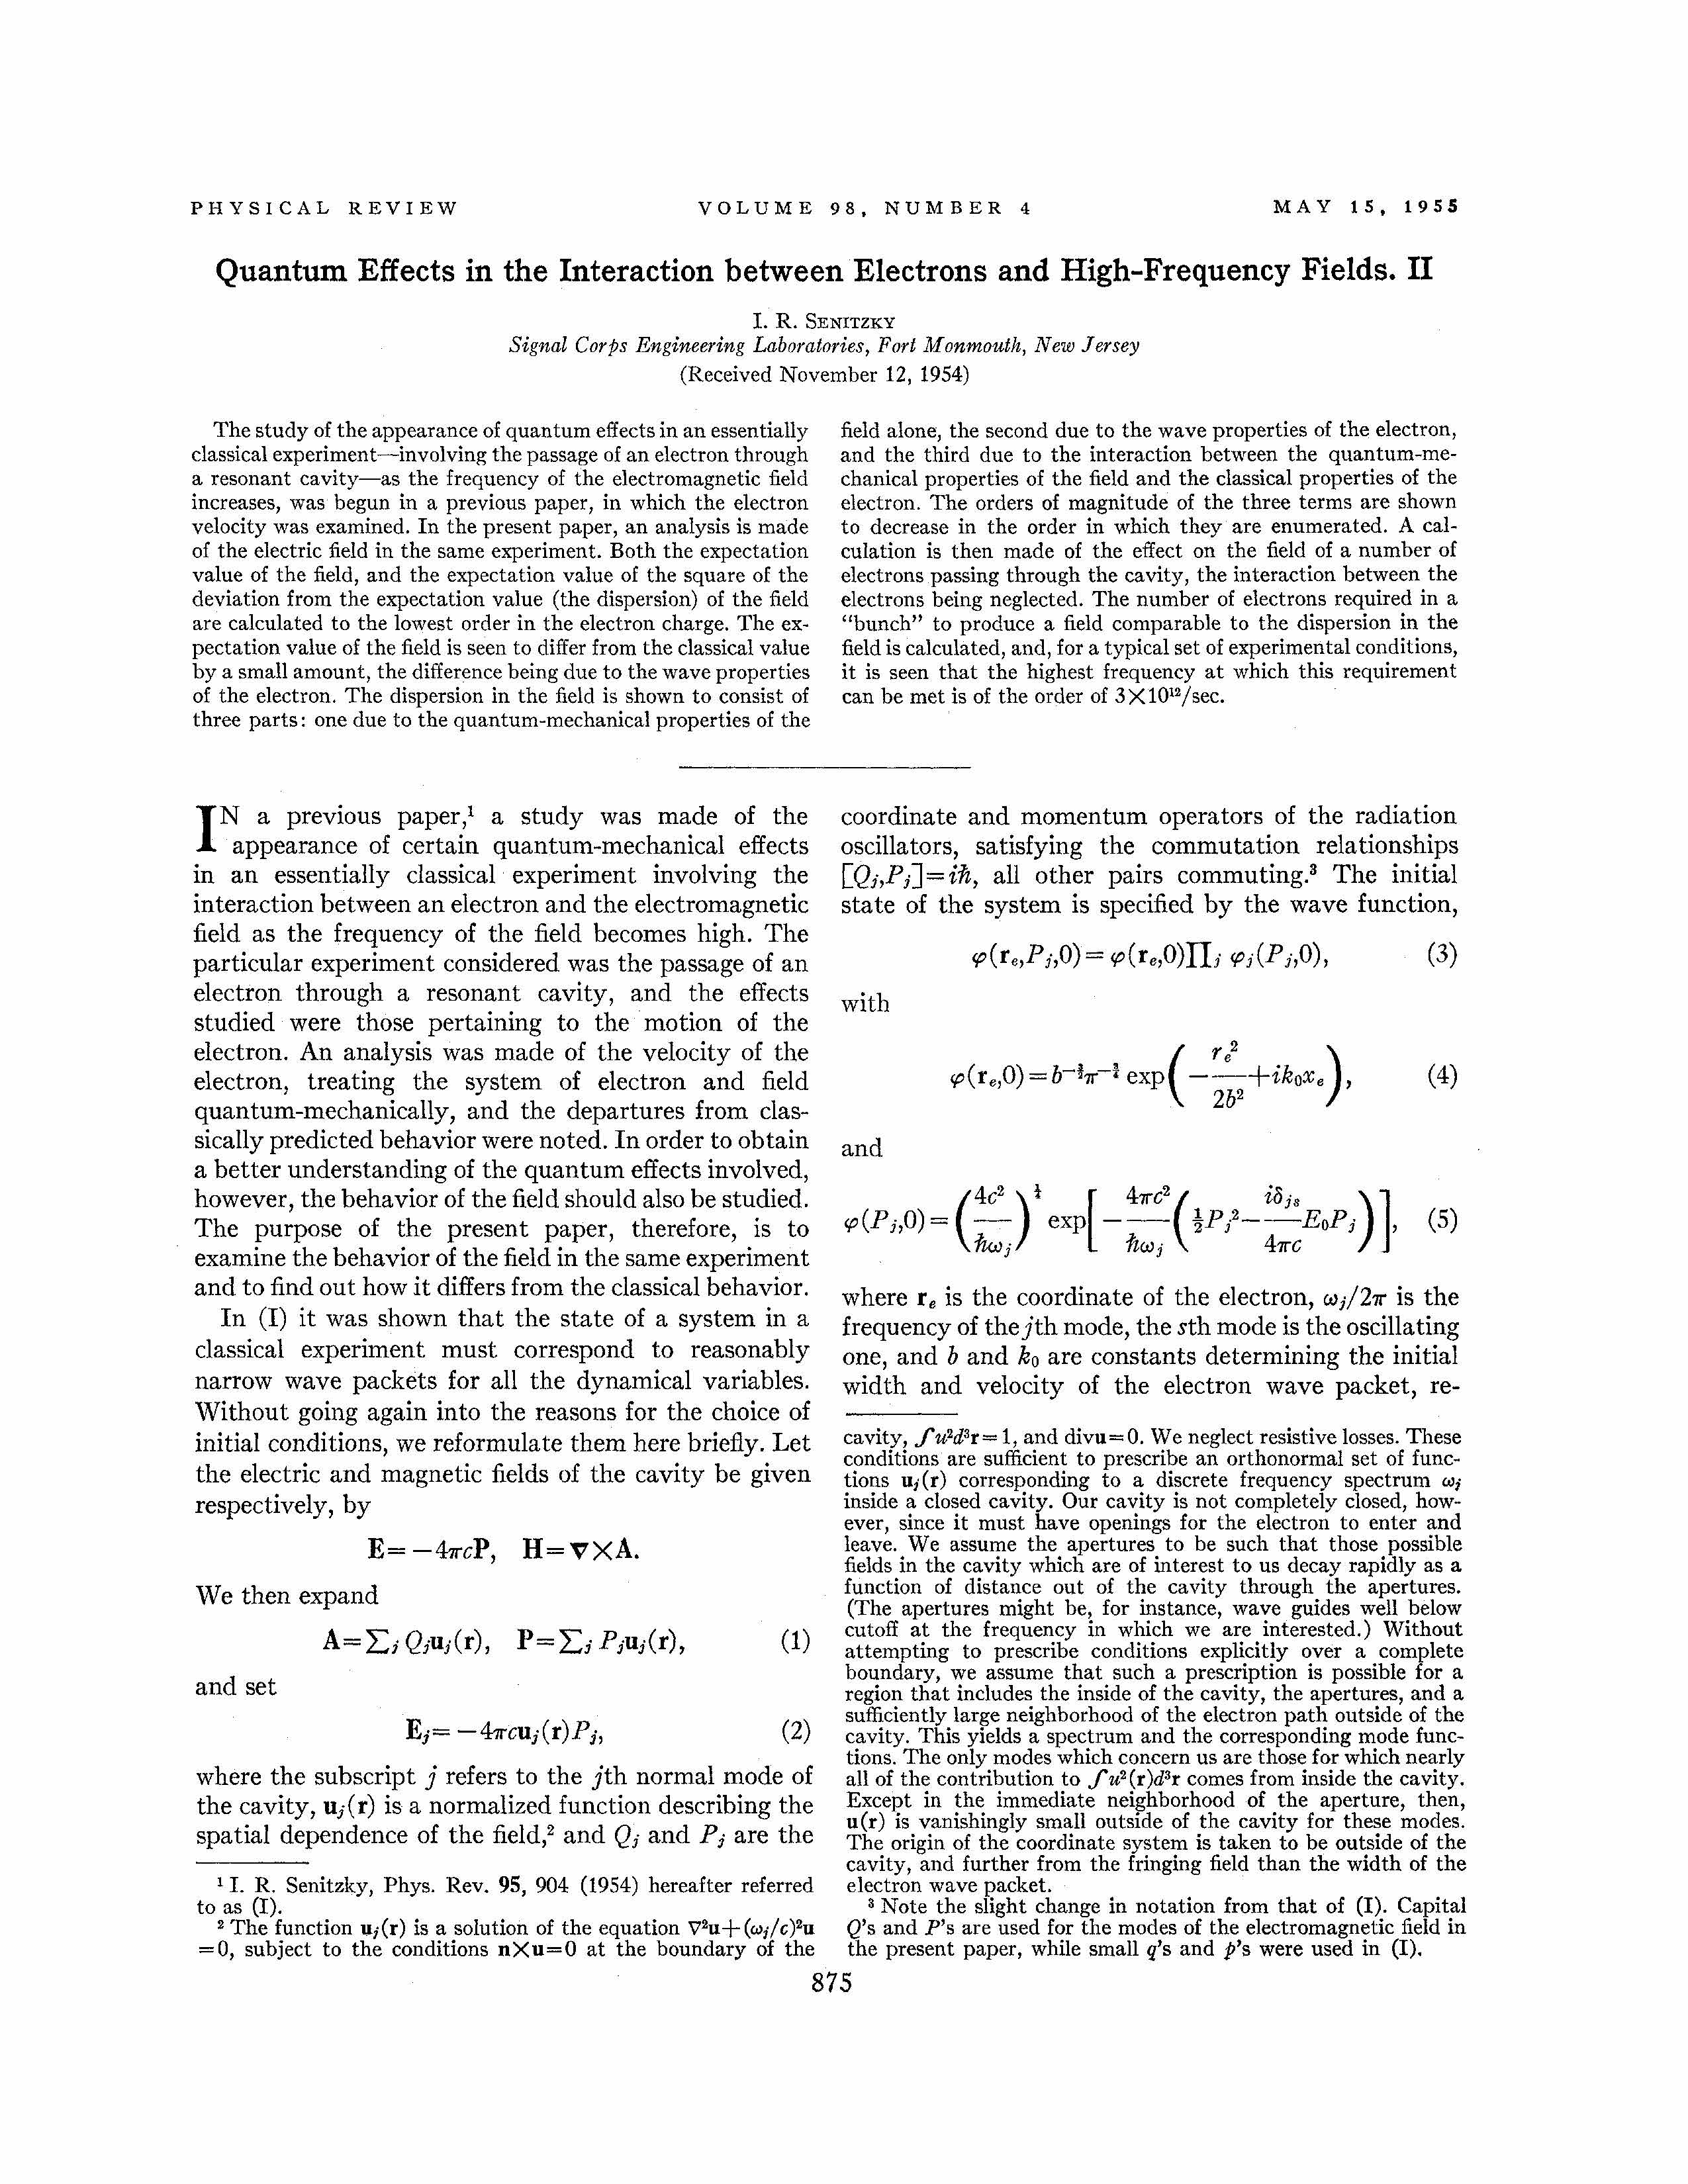

In [36]:
from IPython.display import Image
Image("../data/PhysRev.98.875.jpg", width=1000, height=1000)

Now let's go the other way around and find words most similar to this document:

In [37]:
apsD2V.most_similar( [ apsD2V.docvecs['10.1103/PhysRev.98.875'] ], topn=5) 

[('volts', 0.8236003518104553),
 ('attaining', 0.8067859411239624),
 ('shielding', 0.7597390413284302),
 ('kv', 0.7478094100952148),
 ('vary', 0.7477940917015076)]

We can even look for documents most like a query composed of multiple words:

In [38]:
apsD2V.docvecs.most_similar([ apsD2V['electron']+apsD2V['positron']+apsD2V['neutron']], topn=5 )

[('10.1103/PhysRev.85.1012', 0.7578761577606201),
 ('10.1103/PhysRev.89.631', 0.7375411987304688),
 ('10.1103/PhysRev.108.570', 0.7350585460662842),
 ('10.1103/PhysRev.116.1583', 0.7231032848358154),
 ('10.1103/PhysRev.92.1218', 0.7129611968994141)]

Now let's plot some words and documents against one another with a heatmap:

In [39]:
heatmapMatrix = []
for tagOuter in keywords:
    column = []
    tagVec = apsD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, apsD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrix.append(column)
heatmapMatrix = np.array(heatmapMatrix)

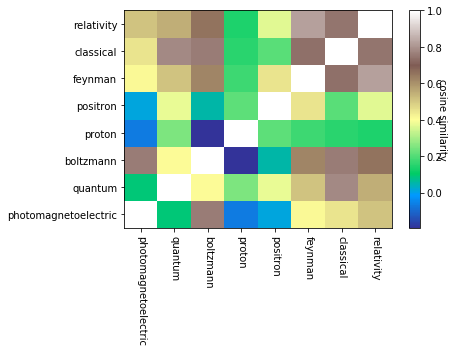

In [40]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrix, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrix.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrix.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(keywords, minor=False)

Now let's look at a heatmap of similarities between the first ten documents in the corpus:

In [41]:
targetDocs = apsDF['doi'][:10]

heatmapMatrixD = []

for tagOuter in targetDocs:
    column = []
    tagVec = apsD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in targetDocs:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, apsD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixD.append(column)
heatmapMatrixD = np.array(heatmapMatrixD)

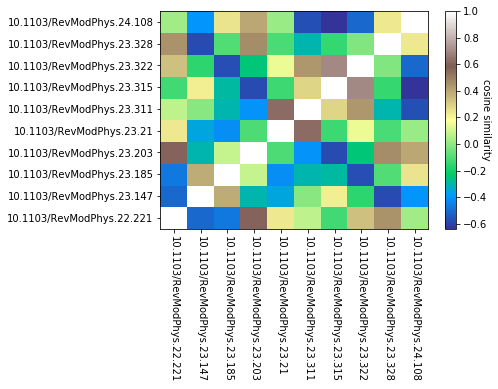

In [42]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixD, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixD.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixD.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(targetDocs, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs, minor=False)

Now let's look at a heatmap of similarities between the first ten documents and our keywords:

In [43]:
heatmapMatrixC = []

for tagOuter in targetDocs:
    column = []
    tagVec = apsD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, apsD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixC.append(column)
heatmapMatrixC = np.array(heatmapMatrixC)

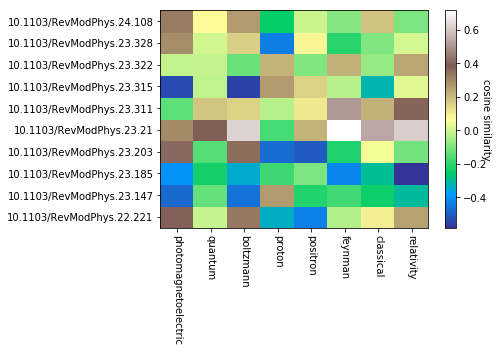

In [44]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixC, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixC.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixC.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs, minor=False)

We will save the model in case we would like to use it again.

In [45]:
apsD2V.save('apsW2V')

We can later load it:

In [46]:
#apsD2V = gensim.models.word2vec.Word2Vec.load('data/apsW2V')

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">Construct cells immediately below this that embed documents related to your final project using `doc2vec`, and explore the relationship between different documents and the word vectors you analyzed in the last exercise. Consider the most similar words to critical documents, analogies (doc _x_ + word _y_), and other additions and subtractions that reveal the structure of similarity and difference within your semantic space. What does this pattern reveal about the documentary organization of your semantic space?

In [43]:
race_apw['tokenized_words'] = race_apw['text'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
race_apw['normalized_words'] = race_apw['tokenized_words'].apply(lambda x: lucem_illud_2020.normalizeTokens(x, lemma=False))


In [44]:
race_apw.head()

,race,url,title,text,tokenized_sents,normalized_sents,tokenized_words,normalized_words
0,African American,/islandora/object/apw%3A12345532?solr_nav%5Bid...,#Incarcerated lives matter,Incarcerated Lives Matter By Lacino Hamilton...,"[[Incarcerated, Lives, Matter, By, Lacino, Ham...","[[incarcerated, lives, matter, lacino, hamilto...","[Incarcerated, Lives, Matter, By, Lacino, Hami...","[incarcerated, lives, matter, lacino, hamilton..."
1,African American,/islandora/object/apw%3A12341353?solr_nav%5Bid...,2014 legislative will prove whether policy mak...,2014 Legislative Session Will Prove Whether Po...,"[[2014, Legislative, Session, Will, Prove, Whe...","[[legislative, session, prove, policy, makers,...","[2014, Legislative, Session, Will, Prove, Whet...","[legislative, session, prove, policy, makers, ..."
2,African American,/islandora/object/apw%3A12343185?solr_nav%5Bid...,4A4L - unsensored,Ladaro Pennix CA written 4 21 14 Positive Gree...,"[[Ladaro, Pennix, CA, written, 4, 21, 14], [Po...","[[ladaro, pennix, written], [positive, greetin...","[Ladaro, Pennix, CA, written, 4, 21, 14, Posit...","[ladaro, pennix, written, positive, greetings,..."
3,African American,/islandora/object/apw%3A12346434?solr_nav%5Bid...,66 days later,66 Days Later Frederick Mason USP Tucson 5548...,"[[66, Days, Later, Frederick, Mason, USP, Tucs...","[[days, later, frederick, mason, usp, tucson],...","[66, Days, Later, Frederick, Mason, USP, Tucso...","[days, later, frederick, mason, usp, tucson, p..."
4,African American,/islandora/object/apw%3A12355950?solr_nav%5Bid...,666,666 Essay by Frederick Radford 7 11 2016 On...,"[[666, Essay, by, Frederick, Radford, 7], [11,...","[[essay, frederick, radford], [reason, chose, ...","[666, Essay, by, Frederick, Radford, 7, 11, 20...","[essay, frederick, radford, reason, chose, tit..."


In [45]:
keywords = ['criminal', 'justice', 'health', 'black', 'white', 'man', 'woman', 'inmate','guard','mental']


In [71]:
taggedDocs = []
for index, row in race_apw.iterrows():
    #Just doing a simple keyword assignment
    docKeywords = [s for s in keywords if s in row['normalized_words']]
    #print(docKeywords)
    docKeywords.append(row['title'])
    taggedDocs.append(gensim.models.doc2vec.LabeledSentence(words = row['normalized_words'], tags = docKeywords))
race_apw['TaggedTexts'] = taggedDocs


In [72]:
race_apw['TaggedTexts'][0]

LabeledSentence(words=['incarcerated', 'lives', 'matter', 'lacino', 'hamilton', 'years', 'ago', 'crises', 'mass', 'incarceration', 'largely', 'thought', 'invisible', 'issue', 'talked', 'exclusively', 'abolitionist', 'circles', 'prison', 'yards', 'mainstream', 'discourse', 'publications', 'groups', 'spanning', 'political', 'spectrum', 'presidential', 'hopefuls', 'parties', 'claim', 'support', 'reducing', 'incarceration', 'rate', 'naive', 'elite', 'level', 'alliances', 'dominant', 'voice', 'taped', 'stapled', 'mounting', 'fiscal', 'pressures', 'unlikely', 'result', 'modest', 'reforms', 'eliminate', 'mass', 'incarceration', 'leading', 'social', 'devastation', 'making', 'permanent', 'underclass', 'maximum', 'cooperation', 'solidarity', 'required', 'incarcerated', 'nonincarcerated', 'people', 'thing', 'incarceration', 'rate', 'increasingly', 'grew', 'decades', 'political', 'influence', 'power', 'groups', 'organizations', 'institutions', 'vested', 'economic', 'interest', 'maintaining', 'worl

In [73]:
apw_D2V = gensim.models.doc2vec.Doc2Vec(race_apw['TaggedTexts'], size = 100) #Limiting to 100 dimensions


/Users/daminisharma/miniconda3/lib/python3.7/site-packages/gensim/models/doc2vec.py:574: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


In [74]:
apw_D2V.most_similar(positive = ['corrupt'], negative = ['prison'], topn = 10)

[('defense', 0.7554227113723755),
 ('petitioned', 0.742622971534729),
 ('evidence', 0.7425581216812134),
 ('overreaction', 0.7304967641830444),
 ('refute', 0.7076342701911926),
 ('rivalry', 0.6951273083686829),
 ('prosecutors', 0.6923014521598816),
 ('genome', 0.6918226480484009),
 ('pervert', 0.6909555196762085),
 ('overzealous', 0.6881304979324341)]

In [75]:
apw_D2V.most_similar(positive = ['corrupt','prison'], topn = 10)

[('penal', 0.851037859916687),
 ('judicial', 0.8178871870040894),
 ('operates', 0.8172930479049683),
 ('immune', 0.8163385391235352),
 ('revamped', 0.7998080253601074),
 ('corrupted', 0.7990375757217407),
 ('unofficially', 0.7922406196594238),
 ('unjustly', 0.7919775247573853),
 ('comitted', 0.7881944179534912),
 ('overhaul', 0.7857221364974976)]

In [76]:
apw_D2V.docvecs.most_similar([apw_D2V['corrupt']], topn=5 )

[('Found!', 0.8707979321479797),
 ('Consolidation: How to cut administrative cost while maximizing programs',
  0.8323367238044739),
 ('In re: "they are not like us"', 0.8301743865013123),
 ('Save us from more collateral damage', 0.8301514387130737),
 ('State of fear in the jurisprudence system', 0.8245868682861328)]

In [77]:
apw_corrupt_prisons = apw_D2V.docvecs.most_similar([ apw_D2V['corrupt']-apw_D2V['prison']], topn=10 )
apw_D2V.docvecs.most_similar([ apw_D2V['corrupt']-apw_D2V['prison']], topn=10 )


[('Wrath, Part II', 0.4620038866996765),
 ('Fight for justice, illegal harsh and excessive sentance and fatally defective and false judgment of convictions, and cruel justice center',
  0.4532984495162964),
 ('Humanities: Prisoners response to authority from a spiritual perspective',
  0.45088157057762146),
 ('Judge the cheating', 0.44925230741500854),
 ("Kevin's update letter KUL #22, June 2014", 0.43702414631843567),
 ('The genetic and social origins of sex crimes: What theologians, police, and prosecutors do not want you to know as jurors',
  0.4350111782550812),
 ('Imposed incompetence', 0.434849351644516),
 ("Prison sex crimes and abuse: Options and defenses with the truth about the prison rape elimination act of 2003 and why it's ineffective",
  0.4326290190219879),
 ('This way or that way', 0.4254138469696045),
 ('District attorney suppresses evidence of innocence in decades-old murder case!',
  0.41814935207366943)]

In [78]:
apw_corrupt_plus_prisons = apw_D2V.docvecs.most_similar([ apw_D2V['corrupt']+apw_D2V['prison']], topn=10 )
apw_D2V.docvecs.most_similar([ apw_D2V['corrupt']+apw_D2V['prison']], topn=10 )

[('The other side of the story', 0.7167322039604187),
 ('The myth behind life at SNY facilities', 0.6757981181144714),
 ('Dear sirs, first I would like', 0.6558322906494141),
 ('In search of the truth', 0.6388050317764282),
 ('Inmates could help resolve prison debacle', 0.6276293992996216),
 ("Amerikkka's death tombs", 0.6002585291862488),
 ('Unlawful relations between inmates and administrative officials',
  0.5983568429946899),
 ('National intelligence for African American communities party',
  0.583647608757019),
 ('The poetry of prison', 0.583084762096405),
 ('Change is coming, part 2', 0.5737737417221069)]

In [79]:
#apw_D2V.most_similar([apw_D2V.docvecs['The other side of the story'] + apw_D2V['law']], topn=5) 


In [80]:
# heatmapMatrix = []
# for tagOuter in keywords:
#     column = []
#     tagVec = apw_D2V.docvecs[tagOuter].reshape(1, -1)
#     for tagInner in keywords:
#         column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, apw_D2V.docvecs[tagInner].reshape(1, -1))[0][0])
#     heatmapMatrix.append(column)
# heatmapMatrix = np.array(heatmapMatrix)

In [81]:
# fig, ax = plt.subplots()
# hmap = ax.pcolor(heatmapMatrix, cmap='terrain')
# cbar = plt.colorbar(hmap)

# cbar.set_label('cosine similarity', rotation=270)
# a = ax.set_xticks(np.arange(heatmapMatrix.shape[1]) + 0.5, minor=False)
# a = ax.set_yticks(np.arange(heatmapMatrix.shape[0]) + 0.5, minor=False)

# a = ax.set_xticklabels(keywords, minor=False, rotation=270)
# a = ax.set_yticklabels(keywords, minor=False)

In [82]:
apw_corrupt_prisons_list = [x[0] for x in apw_corrupt_prisons]

In [83]:
apw_corrupt_plus_prisons_list = [x[0] for x in apw_corrupt_plus_prisons]

In [84]:
apw_corrupt_prisons_list

['Wrath, Part II',
 'Fight for justice, illegal harsh and excessive sentance and fatally defective and false judgment of convictions, and cruel justice center',
 'Humanities: Prisoners response to authority from a spiritual perspective',
 'Judge the cheating',
 "Kevin's update letter KUL #22, June 2014",
 'The genetic and social origins of sex crimes: What theologians, police, and prosecutors do not want you to know as jurors',
 'Imposed incompetence',
 "Prison sex crimes and abuse: Options and defenses with the truth about the prison rape elimination act of 2003 and why it's ineffective",
 'This way or that way',
 'District attorney suppresses evidence of innocence in decades-old murder case!']

In [85]:
apw_corrupt_plus_prisons_list

['The other side of the story',
 'The myth behind life at SNY facilities',
 'Dear sirs, first I would like',
 'In search of the truth',
 'Inmates could help resolve prison debacle',
 "Amerikkka's death tombs",
 'Unlawful relations between inmates and administrative officials',
 'National intelligence for African American communities party',
 'The poetry of prison',
 'Change is coming, part 2']

In [86]:
targetDocs1 = race_apw[race_apw['title'].isin(apw_corrupt_prisons_list)]['title']
targetDocs2 = race_apw[race_apw['title'].isin(apw_corrupt_plus_prisons_list)]['title']


In [87]:
targetDocs1

232     Fight for justice, illegal harsh and excessive...
472     Prison sex crimes and abuse: Options and defen...
591     The genetic and social origins of sex crimes: ...
900                                        Wrath, Part II
1046                                 Imposed incompetence
1060                                   Judge the cheating
1577    District attorney suppresses evidence of innoc...
1682    Humanities: Prisoners response to authority fr...
1794             Kevin's update letter KUL #22, June 2014
2197                                 This way or that way
Name: title, dtype: object

In [88]:
#targetDocs = race_apw['title'][30:40]

heatmapMatrixD = []

for tagOuter in targetDocs1:
    column = []
    tagVec = apw_D2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in targetDocs1:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, apw_D2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixD.append(column)
heatmapMatrixD = np.array(heatmapMatrixD)

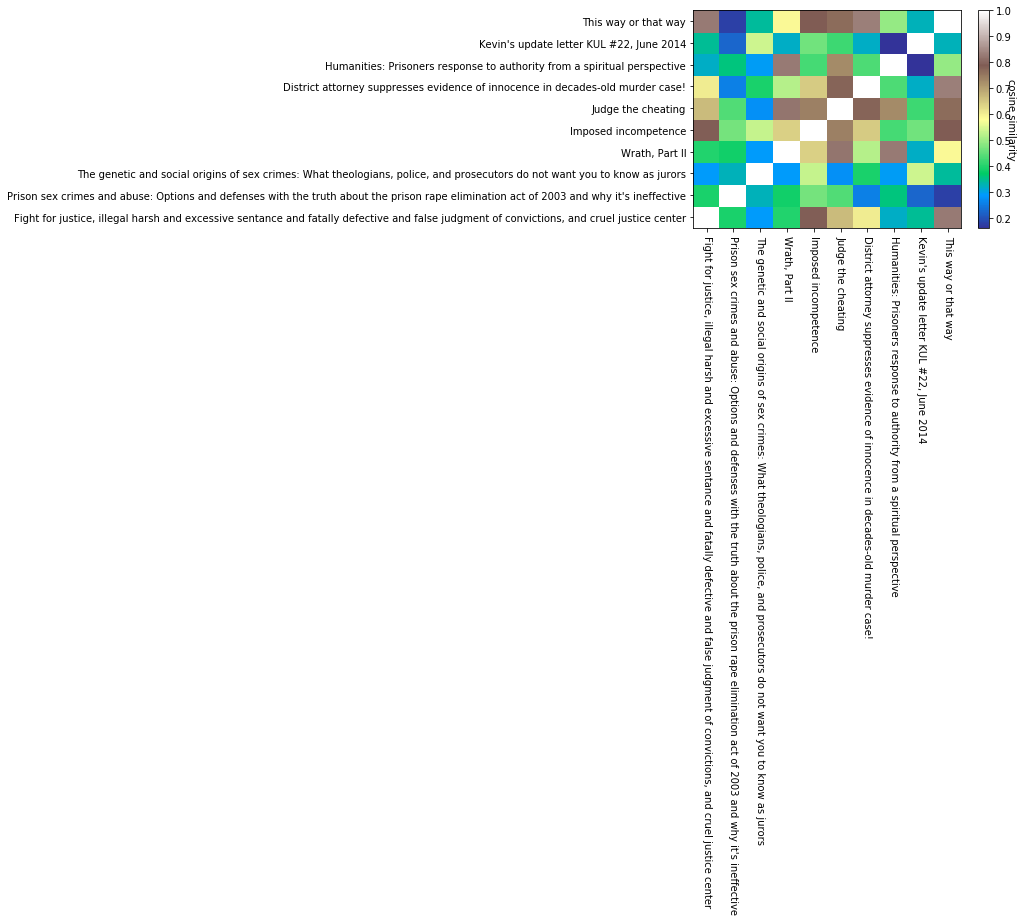

In [89]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixD, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixD.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixD.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(targetDocs1, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs1, minor=False)

In [90]:
heatmapMatrixD = []

for tagOuter in targetDocs2:
    column = []
    tagVec = apw_D2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in targetDocs2:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, apw_D2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixD.append(column)
heatmapMatrixD = np.array(heatmapMatrixD)

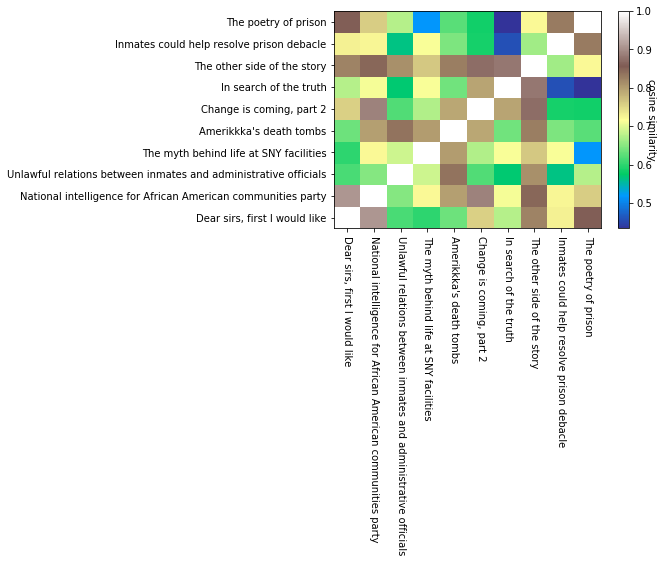

In [91]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixD, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixD.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixD.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(targetDocs2, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs2, minor=False)

In [92]:
heatmapMatrixC = []

for tagOuter in targetDocs1:
    column = []
    tagVec = apw_D2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, apw_D2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixC.append(column)
heatmapMatrixC = np.array(heatmapMatrixC)

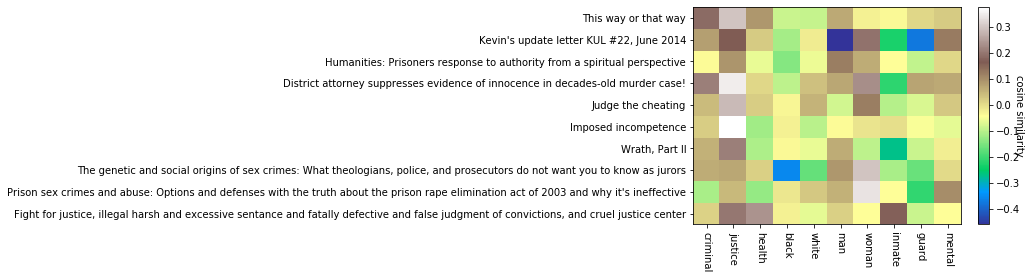

In [94]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixC, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixC.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixC.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs1, minor=False)

In [95]:
heatmapMatrixC = []

for tagOuter in targetDocs2:
    column = []
    tagVec = apw_D2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, apw_D2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixC.append(column)
heatmapMatrixC = np.array(heatmapMatrixC)

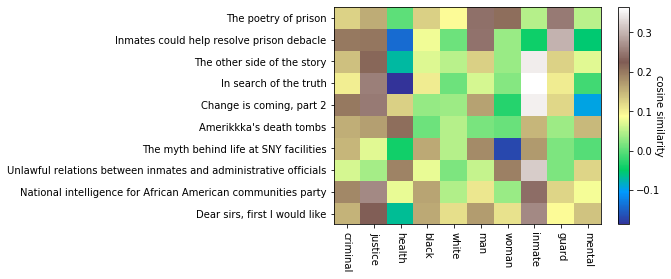

In [96]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixC, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixC.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixC.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs2, minor=False)

In [97]:
apw_D2V.most_similar(positive = ['sex'], topn = 10)

[('offences', 0.8921988606452942),
 ('consensual', 0.8614306449890137),
 ('underage', 0.8513280153274536),
 ('pornography', 0.8473970890045166),
 ('molestation', 0.8422601222991943),
 ('crimes', 0.8362840414047241),
 ('offenses', 0.8341776132583618),
 ('burglars', 0.8174063563346863),
 ('molesters', 0.8172485828399658),
 ('offenders', 0.8157394528388977)]

In [98]:
apw_D2V.most_similar(positive = ['sex','man'], negative=['woman'], topn = 10)

[('offenders', 0.7887418866157532),
 ('crimes', 0.7876890301704407),
 ('molestation', 0.7727338075637817),
 ('offender', 0.767338752746582),
 ('offences', 0.7558050751686096),
 ('violent', 0.7555233240127563),
 ('offenses', 0.7480795979499817),
 ('deviants', 0.7422593832015991),
 ('underage', 0.7412654161453247),
 ('consensual', 0.7274289727210999)]

In [99]:
apw_D2V.most_similar(positive = ['sex','woman'], negative=['man'], topn = 10)

[('offences', 0.874976634979248),
 ('consensual', 0.8468078374862671),
 ('pornography', 0.8350732326507568),
 ('drug', 0.8277934789657593),
 ('underage', 0.8174712657928467),
 ('burglars', 0.8131975531578064),
 ('molesters', 0.8056457042694092),
 ('child', 0.7995285987854004),
 ('porn', 0.7844871282577515),
 ('offenses', 0.782135546207428)]

In [100]:
apw_sex_man = apw_D2V.docvecs.most_similar([ apw_D2V['sex']+apw_D2V['man']-apw_D2V['woman']], topn=10 )
apw_sex_woman = apw_D2V.docvecs.most_similar([ apw_D2V['sex']+apw_D2V['woman']-apw_D2V['man']], topn=10 )


In [101]:
apw_sex_man_list = [x[0] for x in apw_sex_man]

In [102]:
apw_sex_woman_list = [x[0] for x in apw_sex_woman]

In [103]:
targetDocs1 = race_apw[race_apw['title'].isin(apw_sex_man_list)]['title']
targetDocs2 = race_apw[race_apw['title'].isin(apw_sex_woman_list)]['title']


In [104]:
#targetDocs = race_apw['title'][30:40]

heatmapMatrixD = []

for tagOuter in targetDocs1:
    column = []
    tagVec = apw_D2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in targetDocs1:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, apw_D2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixD.append(column)
heatmapMatrixD = np.array(heatmapMatrixD)

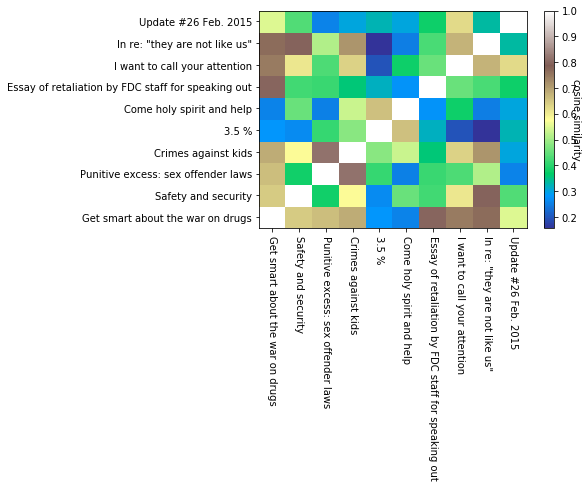

In [105]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixD, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixD.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixD.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(targetDocs1, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs1, minor=False)

In [106]:
#targetDocs = race_apw['title'][30:40]

heatmapMatrixD = []

for tagOuter in targetDocs2:
    column = []
    tagVec = apw_D2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in targetDocs2:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, apw_D2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixD.append(column)
heatmapMatrixD = np.array(heatmapMatrixD)

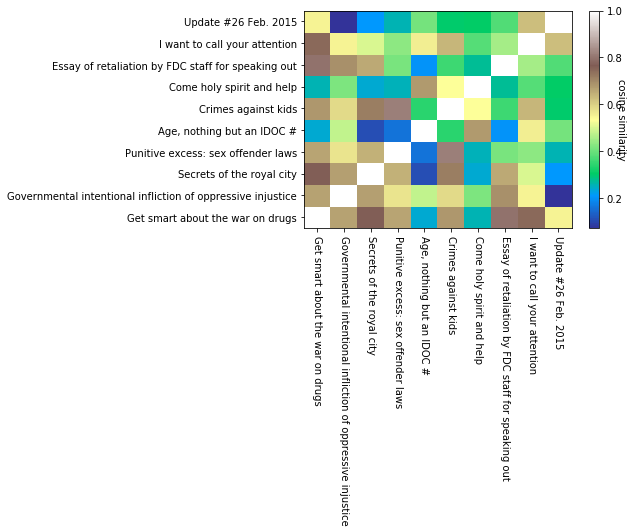

In [107]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixD, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixD.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixD.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(targetDocs2, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs2, minor=False)

In [108]:
heatmapMatrixC = []

for tagOuter in targetDocs1:
    column = []
    tagVec = apw_D2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, apw_D2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixC.append(column)
heatmapMatrixC = np.array(heatmapMatrixC)

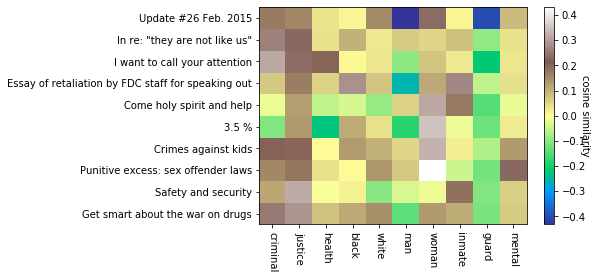

In [109]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixC, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixC.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixC.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs1, minor=False)

In [110]:
heatmapMatrixC = []

for tagOuter in targetDocs2:
    column = []
    tagVec = apw_D2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, apw_D2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixC.append(column)
heatmapMatrixC = np.array(heatmapMatrixC)

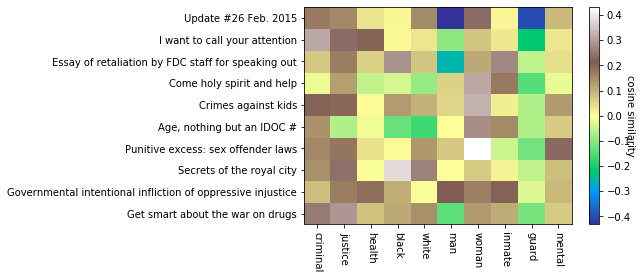

In [111]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixC, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixC.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixC.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs2, minor=False)

### Takeaways

In the above exercise, I looked at the relationship between the words "corrupt" and "prison" and, accordingly, how documents similar to these word vectors relate to each other.

First, we see that the words that are most similar to "corrupt" plus "prison" are very different from the words that are most similar to "corrupt" minus "prison". This made me want to explore the documents that are most similar to each of those vectors. Accordingly, targetdocs1 is a list of 10 documents that are most similar to "corrupt" minus "prisons" ; targetdocs2 is a list of 10 documents that are most similar to "corrupt" plus "prisons".

I then plotted targetdocs1 against each other and targetdocs2 against each other, respectively, to see how similar these documents were.

Interestingly, targetdocs1 (first plot) are quite dissimilar from each other, whereas targetdocs2 (second plot) have a lot more similarity. This suggests that the vectors related to "corrupt" but NOT related to "prison", in this corpus, tend to be quite diverse and those documents don't relate closely to each other. On the other hand when we consider vectors of words related to "corrupt" plus "prisons", those documents tend to share a lot of similarity.

I repeated the exercise with a different combination of words: "sex"+"man"-"woman" and "sex"+"woman"-"man". Since sexual assault in prison and sex offender laws are pretty controversial topics surrounding the criminal justice system, I wanted to see if the documents that discussed these issues differentially by men/women would be different.

We can immediately see that the words associated with each of these vectors are different. "sex"+"man"-"woman" gives a lot of violent words, including: "violent", "molestation", "crimes", "deviant". "sex"+"woman"-"man", however, gives many different words: "underage","pornography", "drug", "child" - far less "aggressive" words. I then looked at the similarity among the top 10 documents closest to each of those vectors. From the graphs above, it seems like the 10 documents more similar to "sex"+"man"-"woman" are slightly less related to each other than the documents closest to "sex"+"woman"-"man". Perhaps this suggests that documents discussing sex+woman, minus man, explore a lot more similar topics than documents discussing sex+man, minus woman.

# Projection

We can also project word vectors to an arbitray semantic dimension. To demonstrate this possibility, let's first load a model trained with New York Times news articles. 

In [267]:
nytimes_model = gensim.models.KeyedVectors.load_word2vec_format('../data/nytimes_cbow.reduced.txt')


In [285]:
nytimes_model

First we can visualize with dimension reduction

In [268]:
#words to create dimensions
tnytTargetWords = ['man','him','he', 'woman', 'her', 'she', 'black','blacks','African', 'white', 'whites', 'Caucasian', 'rich', 'richer', 'richest', 'expensive', 'wealthy', 'poor', 'poorer', 'poorest', 'cheap', 'inexpensive']
#words we will be mapping
tnytTargetWords += ["doctor","lawyer","plumber","scientist","hairdresser", "nanny","carpenter","entrepreneur","musician","writer", "banker","poet","nurse", "steak", "bacon", "croissant", "cheesecake", "salad", "cheeseburger", "vegetables", "beer", "wine", "pastry", "basketball", "baseball", "boxing", "softball", "volleyball", "tennis", "golf", "hockey", "soccer"]


wordsSubMatrix = []
for word in tnytTargetWords:
    wordsSubMatrix.append(nytimes_model[word])
wordsSubMatrix = np.array(wordsSubMatrix)
#wordsSubMatrix

In [269]:
pcaWordsNYT = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_dataNYT = pcaWordsNYT.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWordsNYT = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_dataNYT)

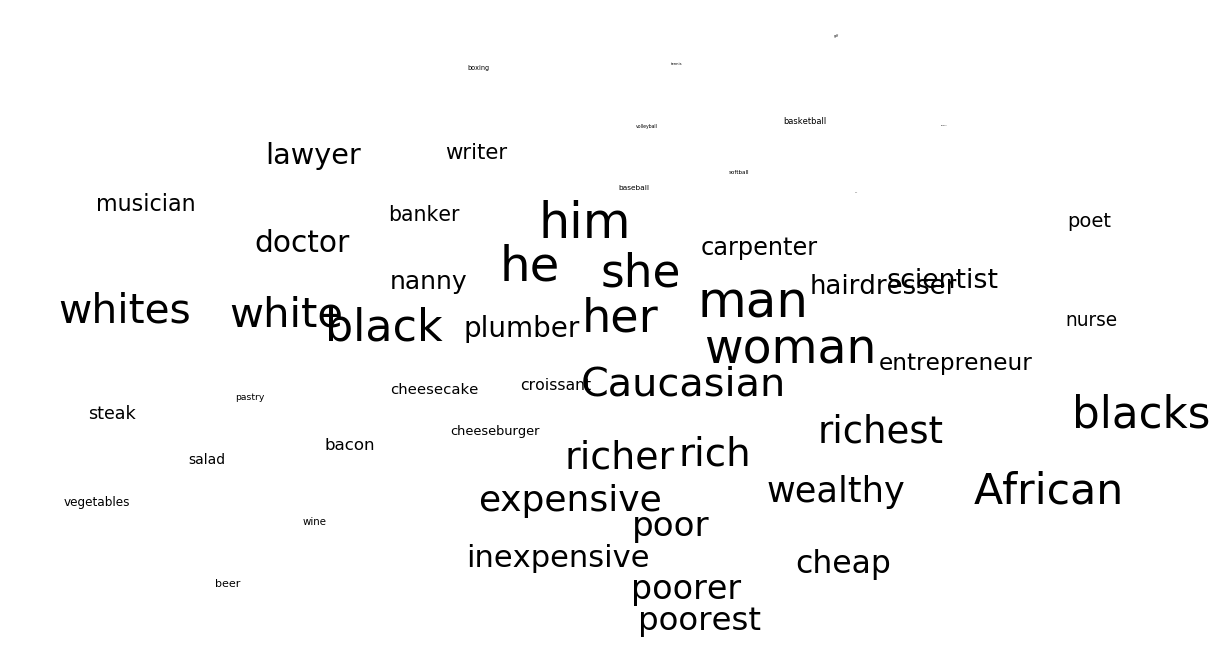

In [270]:
fig = plt.figure(figsize = (20,12))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWordsNYT[:, 0], tsneWordsNYT[:, 1], alpha = 0) #Making the points invisible
for i, word in enumerate(tnytTargetWords):
    ax.annotate(word, (tsneWordsNYT[:, 0][i],tsneWordsNYT[:, 1][i]), size =  50 * (len(tnytTargetWords) - i) / len(tnytTargetWords))
plt.xticks(())
plt.yticks(())
plt.show()

Define some convenient functions for getting dimensions. 

In [271]:
def normalize(vector):
    normalized_vector = vector / np.linalg.norm(vector)
    return normalized_vector

def dimension(model, positives, negatives):
    diff = sum([normalize(model[x]) for x in positives]) - sum([normalize(model[y]) for y in negatives])
    return diff

Let's calculate three dimensions: gender, race, and class.

In [272]:
Gender = dimension(nytimes_model, ['man','him','he'], ['woman', 'her', 'she'])
Race = dimension(nytimes_model, ['black','blacks','African'], ['white', 'whites', 'Caucasian'])
Class = dimension(nytimes_model, ['rich', 'richer', 'richest', 'expensive', 'wealthy'], ['poor', 'poorer', 'poorest', 'cheap', 'inexpensive'])

Here we have some words.

In [273]:
Occupations = ["doctor","lawyer","plumber","scientist","hairdresser", "nanny","carpenter","entrepreneur","musician","writer", "banker","poet","nurse"]

Foods = ["steak", "bacon", "croissant", "cheesecake", "salad", "cheeseburger", "vegetables", "beer", "wine", "pastry"]

Sports  = ["basketball", "baseball", "boxing", "softball", "volleyball", "tennis", "golf", "hockey", "soccer"]

Define a function to project words in a word list to each of the three dimensions.

In [274]:
def makeDF(model, word_list):
    g = []
    r = []
    c = []
    for word in word_list:
        g.append(sklearn.metrics.pairwise.cosine_similarity(nytimes_model[word].reshape(1,-1), Gender.reshape(1,-1))[0][0])
        r.append(sklearn.metrics.pairwise.cosine_similarity(nytimes_model[word].reshape(1,-1), Race.reshape(1,-1))[0][0])
        c.append(sklearn.metrics.pairwise.cosine_similarity(nytimes_model[word].reshape(1,-1), Class.reshape(1,-1))[0][0])
    df = pandas.DataFrame({'gender': g, 'race': r, 'class': c}, index = word_list)
    return df

Get the projections.

In [275]:
OCCdf = makeDF(nytimes_model, Occupations) 
Fooddf = makeDF(nytimes_model, Foods)
Sportsdf = makeDF(nytimes_model, Sports)

Define some useful functions for plotting.

In [276]:
def Coloring(Series):
    x = Series.values
    y = x-x.min()
    z = y/y.max()
    c = list(plt.cm.rainbow(z))
    return c

def PlotDimension(ax,df, dim):
    ax.set_frame_on(False)
    ax.set_title(dim, fontsize = 20)
    colors = Coloring(df[dim])
    for i, word in enumerate(df.index):
        ax.annotate(word, (0, df[dim][i]), color = colors[i], alpha = 0.6, fontsize = 12)
    MaxY = df[dim].max()
    MinY = df[dim].min()
    plt.ylim(MinY,MaxY)
    plt.yticks(())
    plt.xticks(())

Plot the occupational words in each of the three dimensions.

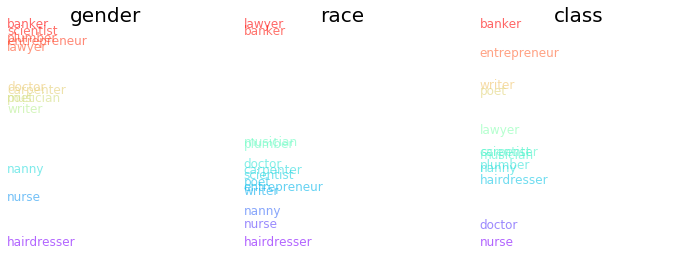

In [277]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, OCCdf, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, OCCdf, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, OCCdf, 'class')
plt.show()

Foods:

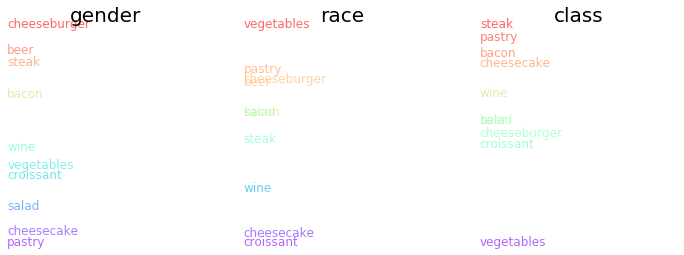

In [278]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, Fooddf, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, Fooddf, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, Fooddf, 'class')
plt.show()

Sports:

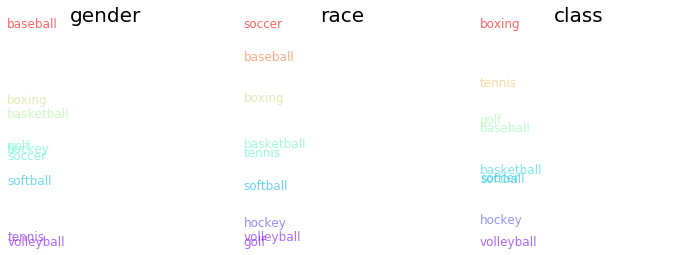

In [279]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, Sportsdf, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, Sportsdf, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, Sportsdf, 'class')
plt.show()

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">Construct cells immediately below this that embed documents related to your final project, then generate meaningful semantic dimensions based on your theoretical understanding of the semantic space (i.e., by subtracting semantically opposite word vectors) and project another set of word vectors onto those dimensions. Interpret the meaning of these projections for your analysis. Which of the dimensions you analyze explain the most variation in the projection of your words and why? 

<span style="color:red">***Stretch***: Average together multiple antonym pairs to create robust semantic dimensions. How do word projections on these robust dimensions differ from single-pair dimensions?

In [298]:
#apw_W2V_1.wv

In [297]:
#apw_W2V = gensim.models.word2vec.Word2Vec.load('apw_W2V_1')

In [296]:
#apw_W2V

In [299]:
#apsD2V = gensim.models.word2vec.Word2Vec.load('data/apsW2V')

#apw_model = gensim.models.KeyedVectors.load_word2vec_format('apw_W2V_1')

apw_model = gensim.models.word2vec.Word2Vec.load('apw_W2V_1').wv

In [300]:
apw_model

In [308]:
#words to create dimensions
tnytTargetWords = ['man', 'woman', 'black','blacks','african', 'white', 'whites', 'caucasian', 'rich', 'richer', 'richest', 'expensive', 'wealthy', 'poor', 'poorer', 'poorest', 'cheap', 'inexpensive']
#words we will be mapping
tnytTargetWords += ["prison","inmate","guard","justice","society","law","crime","mental","health"]


wordsSubMatrix = []
for word in tnytTargetWords:
    wordsSubMatrix.append(apw_model[word])
wordsSubMatrix = np.array(wordsSubMatrix)
#wordsSubMatrix

In [310]:
pcaWords_apw = sklearn.decomposition.PCA(n_components = 25).fit(wordsSubMatrix)
reducedPCA_data_apw = pcaWords_apw.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWords_apw = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_data_apw)

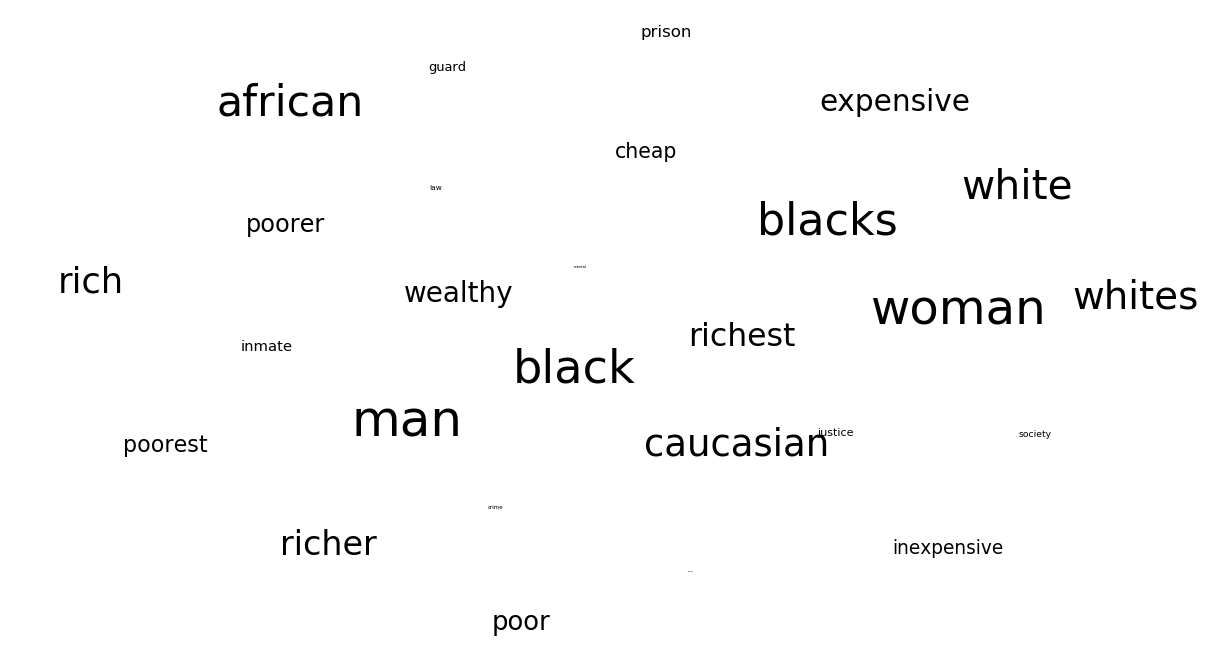

In [311]:
fig = plt.figure(figsize = (20,12))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords_apw[:, 0], tsneWords_apw[:, 1], alpha = 0) #Making the points invisible
for i, word in enumerate(tnytTargetWords):
    ax.annotate(word, (tsneWords_apw[:, 0][i],tsneWords_apw[:, 1][i]), size =  50 * (len(tsneWords_apw) - i) / len(tsneWords_apw))
plt.xticks(())
plt.yticks(())
plt.show()

In [312]:
Gender = dimension(apw_model, ['man','men','male'], ['woman', 'women', 'female'])
Race = dimension(apw_model, ['black','blacks','african'], ['white', 'whites', 'caucasian'])
Class = dimension(apw_model, ['rich', 'richer', 'richest', 'expensive', 'wealthy'], ['poor', 'poorer', 'poorest', 'cheap', 'inexpensive'])


In [318]:
guard_words = [x[0] for x in apw_W2V_1.most_similar(positive=['guard'],topn=20)]

In [319]:
inmate_words = [x[0] for x in apw_W2V_1.most_similar(positive=['inmate'],topn=20)]

In [320]:
justice_words = [x[0] for x in apw_W2V_1.most_similar(positive=['justice'],topn=20)]

In [321]:
health_words = [x[0] for x in apw_W2V_1.most_similar(positive=['health'],topn=20)]

In [323]:
def makeDF(model, word_list):
    g = []
    r = []
    c = []
    for word in word_list:
        g.append(sklearn.metrics.pairwise.cosine_similarity(apw_model[word].reshape(1,-1), Gender.reshape(1,-1))[0][0])
        r.append(sklearn.metrics.pairwise.cosine_similarity(apw_model[word].reshape(1,-1), Race.reshape(1,-1))[0][0])
        c.append(sklearn.metrics.pairwise.cosine_similarity(apw_model[word].reshape(1,-1), Class.reshape(1,-1))[0][0])
    df = pandas.DataFrame({'gender': g, 'race': r, 'class': c}, index = word_list)
    return df

In [324]:
guard_df = makeDF(apw_model, guard_words) 
inmate_df = makeDF(apw_model, inmate_words)
justice_df = makeDF(apw_model, justice_words)
health_df = makeDF(apw_model, health_words)

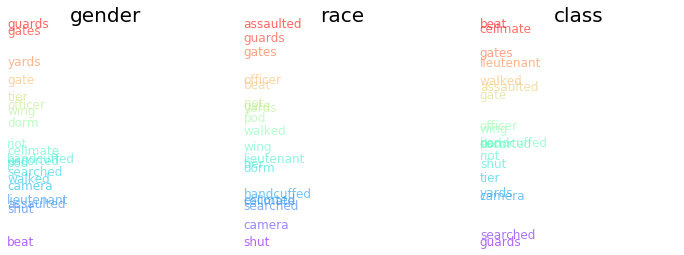

In [325]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, guard_df, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, guard_df, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, guard_df, 'class')
plt.show()

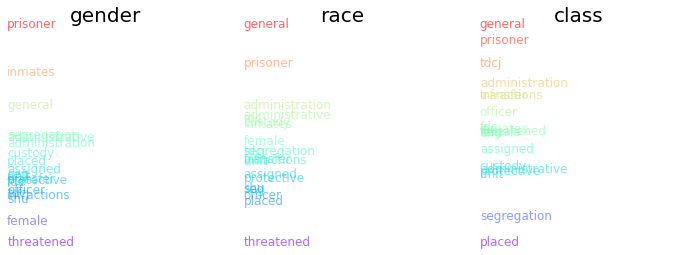

In [326]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, inmate_df, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, inmate_df, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, inmate_df, 'class')
plt.show()

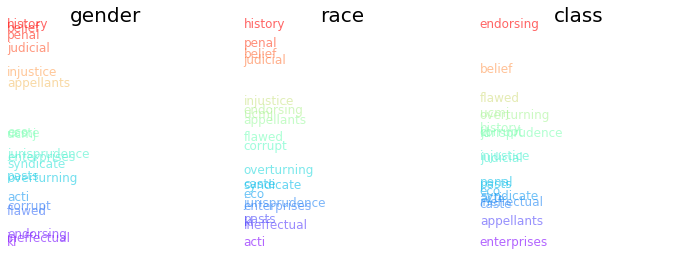

In [327]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, justice_df, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, justice_df, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, justice_df, 'class')
plt.show()

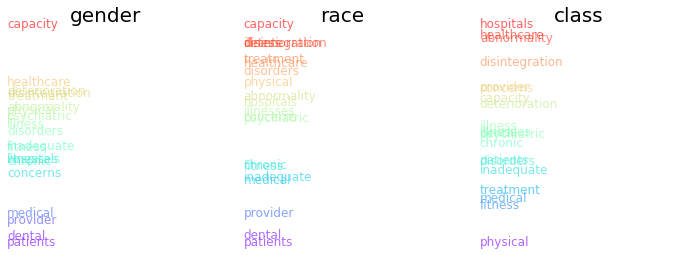

In [328]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, health_df, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, health_df, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, health_df, 'class')
plt.show()

### Takeaways

Above, I generated words for three different dimensions: gender, race, class. Then, using my embedded documents, I generated words related to "guard", "inmate", "justice", and "health" and projected those words onto my three dimensions. 

In general, I find the race dimension most interesting, and find that it explains the variation in the projection of words best. Partially, this might be because of the sample - the sample of my corpus is roughly 40% - 60% split between black and white writers, so their experiences can more richly display the differences in the projected words. As in previous exercises, we see stark racial differences in the projections of words related to "guard" - with assaulted on the "black" end and "handcuffed" on another. 

However, race is not good a great dimension for health-related words, while class is. We see words like "disintegration" and "deterioration" on one end, and "treatment" and "medical" on the other. 



# The Score Function

The score function is a simple calculation developed by [Matt Taddy](https://arxiv.org/pdf/1504.07295.pdf) to calculate the likelihood that a given text would have been generated by a word-embedding model by summing the inner product between each pair of the text's word vectors. This relies on a few data files that are not in the git repo due to their size please download and unzip [this](https://github.com/Computational-Content-Analysis-2018/Upcoming/raw/master/data/supplement.zip) (472MB) file in the data directory.

Here, we explore this using a model trained with millions of resumes from the CareerBuilder website (we can't share the private resumes...but we can share a model built with them :-):

In [60]:
resume_model  = gensim.models.word2vec.Word2Vec.load('../data/resumeAll.model')

We can examine the vacabularies of this model by building a word-index map:

In [61]:
vocab = resume_model.wv.index2word

Let's just load the sample and take a look at it. The sentences in each job description are already tokenized and normalized.

In [62]:
sampleDF = pandas.read_csv('../data/SampleJobAds.csv', index_col = False)
#We need to convert the last couple columns from strings to lists
sampleDF['tokenized_sents'] = sampleDF['tokenized_sents'].apply(lambda x: eval(x))
sampleDF['normalized_sents'] = sampleDF['normalized_sents'].apply(lambda x: eval(x))
sampleDF

,Unnamed: 0,hiringOrganization_organizationName,jobDescription,jobLocation_address_region,jobLocation_geo_latitude,jobLocation_geo_longitude,qualifications,responsibilities,tokenized_sents,normalized_sents
0,158844,"Golfsmith International, Inc.","""Sales Associate Tracking Code 220425-971 Job ...",California,33.91918,-118.41647,NaN,"""Ensure each Customer receives exceptional ser...","[[``, Sales, Associate, Tracking, Code, 220425...","[[sales, associate, tracking, code, job, descr..."
1,257645,Intel,For PHY system engineering team within the Wir...,NaN,NaN,NaN,NaN,NaN,"[[For, PHY, system, engineering, team, within,...","[[for, phy, system, engineering, team, within,..."
2,107875,Florida Hospital,*RN Medical Oncology PCU Orlando - Nights* Flo...,Florida,28.53834,-81.37924,NaN,NaN,"[[*RN, Medical, Oncology, PCU, Orlando, -, Nig...","[[medical, oncology, pcu, orlando, florida, ho..."
3,202394,Hitachi Data Systems,Title: Specialist Sales Account Representative...,NaN,NaN,NaN,NaN,NaN,"[[Title, :, Specialist, Sales, Account, Repres...","[[title, specialist, sales, account, represent..."
4,109675,Footprint Retail Services,**Footprint Retail Services** **Job Descriptio...,NaN,NaN,NaN,NaN,A Merchandiser must complete all assigned merc...,"[[**Footprint, Retail, Services**, **Job, Desc...","[[retail, job, title, retail, merchandiser, re..."
5,215973,Home Depot,Position Purpose: Provide outstanding service ...,Indiana,41.13060,-85.12886,NaN,Provide outstanding service to ensure efficien...,"[[Position, Purpose, :, Provide, outstanding, ...","[[position, purpose, provide, outstanding, ser..."
6,207524,Home Depot,The Asset Protection Specialist is primarily r...,New Jersey,40.21455,-74.61932,Must be eighteen years of age or older. Must p...,NaN,"[[The, Asset, Protection, Specialist, is, prim...","[[the, asset, protection, specialist, is, prim..."
7,64426,East West Bank,# Job Description East West Bank is one of the...,California,34.06862,-118.02757,NaN,We are currently seeking a Customer Service Ce...,"[[#, Job, Description, East, West, Bank, is, o...","[[job, description, east, west, bank, is, one,..."
8,245192,IBM,Job Description IBM is seeking to hire a Senio...,NaN,NaN,NaN,NaN,NaN,"[[Job, Description, IBM, is, seeking, to, hire...","[[job, description, ibm, is, seeking, to, hire..."
9,202429,Hitachi Data Systems,Title: Field Solutions Engineer Location: New ...,NaN,NaN,NaN,NaN,Job Functions;Specific duties in this role wil...,"[[Title, :, Field, Solutions, Engineer, Locati...","[[title, field, solutions, engineer, location,..."


Let's define a function to calculate the likelihood of each job description. The idea is borrowed from [Matt Taddy](https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/deepir.ipynb), who shows how a document can be characterized as the inner product of the distance between its words. In other words, this analysis will show which job ads are most likely to find an appropriate pool of workers in the resume bank that generated our word embedding.  

In [63]:
def adprob(ad, model):
    sen_scores = model.score(ad, len(ad))
    ad_score = sen_scores.mean()
    return ad_score

Let's apply this function to every job description.

In [64]:
sampleDF['likelihood'] = sampleDF['normalized_sents'].apply(lambda x: adprob(x, resume_model))

Let's take a look at the top 5 job descriptions that have the highest likelihood.

In [65]:
for ad in sampleDF.sort_values(by = 'likelihood', ascending = False)['jobDescription'][:5]:
    print (ad + '\n\n')

Project Engineering including below jobs: 1. Hardware designing of DCS 2. Software configurations, programming, testing of DCS/PLC 3. Testing and FAT 4. Installation and commissioning. 5. Material ordering, approvals of datasheets. 6. HSE compliance as per HSE directives of HON. BE / B. Tech - Instrumentation / Control / Electronics. **Job:** **Engineering* **Title:** *Systems Engineer* **Location:** *IND-MH-Pune* **Requisition ID:** *00302235*


Like talking on the phone? Enjoy giving great customer service? Use those skills while working flexible,part time hours.


*# Positions:* 2 *Location:* US - UT - Orem *Category:* Engineering


Title: Respiratory Therapy, Intern Location: XX-XX-XX


Title: Position Opening at Illinois Wesleyan University Location: US-IL-Bloomington




Let's take a look at the bottom 5 job descriptions that have the lowest likelihood to be matched by the resumes.

In [66]:
for ad in sampleDF.sort_values(by = 'likelihood')['jobDescription'][:5]:
    print (ad + '\n\n')

Title: Contract Svc Admin Location: United States\-Michigan\-Caledonia Other Locations: JOB SUMMARY: ESSENTIAL DUTIES AND RESPONSIBILITIES: _ Other duties may be assigned:_ Prepare GPO rebate data for upload into STARR system oEnsure accurate data loads oProcess data into required reports oEnsure that GPOs are paid accurately and timely Prepare Sales Tracing data for upload into STARR system oEnsure accurate data loads oProcess data into required reports Prepare Rebate data for upload into STARR system oEnsure accurate data loads oProcess data into required reports oEnsure that distributors are accurately taking rebates against open invoices Manage work flow throughout the sales contracting process Ensure compliance with contract policies and performance requirements Assist in the preparation of charts and sales reports and analytics for customers and Management oQuarterly Reports oSales Tracing Answers customers and internal sale/customer service staff questions regarding pricing Mana

We can do the same for phrases corresponding to job skills.

In [67]:
adprob([["python", "programming"]], resume_model)

-14.355247

In [68]:
adprob([["julia", "programming"]], resume_model)

-33.427353

Basic programming appears to be more likely in this pool of resumes than python programming. 

We can also do some simple statistics. Unfortunately, we don't have a large sample here. Nevertheless, let's first look at the mean likelihood score of each hiring organization. Some organizations will do well to hire on CareerBuilder...while others will not.

In [69]:
sampleDF.groupby("hiringOrganization_organizationName")[['likelihood']].mean().sort_values('likelihood', ascending = False)

,likelihood
hiringOrganization_organizationName,
Honeywell,-25.974749
Legrand North America,-40.500500
Franciscan St. Eilzabeth Health,-43.167206
Illinois Wesleyan University,-52.681591
Gold's Gym,-75.230896
Jewel-Osco,-80.965462
Ingersoll Rand,-81.494949
Kaiser Permanente,-85.523113
Hallmark Health,-86.037094


We can also look at the mean likelihood of each state.

In [70]:
sampleDF.groupby("jobLocation_address_region")[['likelihood']].mean().sort_values('likelihood', ascending = False)

,likelihood
jobLocation_address_region,
Utah,-40.500500
Montana,-63.730721
Connecticut,-67.623466
Kansas,-85.259682
Tennessee,-93.188822
Illinois,-93.989101
New Hampshire,-94.109772
Georgia,-102.271820
South Carolina,-103.527328


You would increase the sample size if you want to do a more serious study.

## <span style="color:red">*Exercise 4a*</span>

<span style="color:red">**Do only 4a or 4b.** Construct cells immediately below this that calculate the scores for a small sample of documents from outside your corpus to identify which are *closest* to your corpus. Then calculate the scores for a few phrases or sentences to identify the ones most likely to have appeared in your corpus. Interrogate patterns associated with these document/phrase scores (e.g., which companies produced job ads most or least likely to find jobseekers in the resume corpus?) What do these patterns suggest about the boundaries of your corpus?

In [112]:
apw_W2V_1 = gensim.models.word2vec.Word2Vec(race_apw['normalized_sents'].sum(),hs=1, negative=0 )


In [113]:
#apw_model = gensim.models.word2vec.Word2Vec.load('apw_W2V_1')

In [123]:
sample_releases = senReleasesDF.sample(1000)

In [124]:
sample_releases.head()

,category,filePath,text,tokenized_sents,normalized_sents
3281,Kennedy,../data/grimmerPressReleases/Kennedy/03Oct2007...,FOR IMMEDIATE RELEASE Mr Preside...,"[[FOR, IMMEDIATE, RELEASE], [Mr, President], [...","[[immediate, release], [mr, president], [m, pl..."
2252,Kennedy,../data/grimmerPressReleases/Kennedy/26Jul2006...,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,"[[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, REL...","[[immediate, release, immediate, release], [wa..."
2738,Kennedy,../data/grimmerPressReleases/Kennedy/16Feb2006...,FOR IMMEDIATE RELEASE Washington DC...,"[[FOR, IMMEDIATE, RELEASE], [Washington, DC], ...","[[immediate, release], [washington, dc], [toda..."
2131,Kohl,../data/grimmerPressReleases/Kohl/29Jul2005Koh...,KOHL SECURES FUNDING FOR TRANSPORTATION AND IN...,"[[KOHL, SECURES, FUNDING, FOR, TRANSPORTATION,...","[[kohl, secures, funding, transportation, infr..."
2767,Kennedy,../data/grimmerPressReleases/Kennedy/25May2006...,FOR IMMEDIATE RELEASE All of the men...,"[[FOR, IMMEDIATE, RELEASE], [All, of, the, men...","[[immediate, release], [men, women, legal, res..."


In [125]:
sample_releases.groupby('category').count()

,filePath,text,tokenized_sents,normalized_sents
category,,,,
Kennedy,427,427,427,427
Kerry,267,267,267,267
Klobuchar,92,92,92,92
Kohl,80,80,80,80
Kyl,134,134,134,134


In [126]:
def adprob(ad, model):
    sen_scores = model.score(ad, len(ad))
    ad_score = sen_scores.mean()
    return ad_score

In [127]:
sample_releases['likelihood'] = sample_releases['normalized_sents'].apply(lambda x: adprob(x, apw_W2V_1))


In [128]:
for text in sample_releases.sort_values(by = 'likelihood', ascending = False)['filePath'][:5]:
    print (text + '\n\n')

../data/grimmerPressReleases/Kerry/01Nov2005Kerry39.txt


../data/grimmerPressReleases/Kennedy/31Jan2007Kennedy7.txt


../data/grimmerPressReleases/Kerry/01Mar2007Kerry443.txt


../data/grimmerPressReleases/Kerry/26Jun2007Kerry285.txt


../data/grimmerPressReleases/Kerry/13Oct2006Kerry20.txt




In [129]:
for text in sample_releases.sort_values(by = 'likelihood', ascending = False)['text'][:5]:
    print (text + '\n\n')

       Releases                                                                                                                                           11 01 2005 Kerry s June 2005 letter to the Intelligence Committee                                                                                                                                                                                                                                                                                                                                                                                                                                           20510                                                                                                                                                                                          Contact           Sitemap            


         FOR IMMEDIATE RELEASE  Washington  D C  Senator Edward M  Kennedy  Chairman of the Health  Education  Labor  and P

In [130]:
for text in sample_releases.sort_values(by = 'likelihood')['filePath'][:5]:
    print (text + '\n\n')

../data/grimmerPressReleases/Kennedy/19Apr2007Kennedy10.txt


../data/grimmerPressReleases/Kohl/6Oct2005Kohl25.txt


../data/grimmerPressReleases/Kennedy/12Dec2007Kennedy7.txt


../data/grimmerPressReleases/Kennedy/03Dec2007Kennedy6.txt


../data/grimmerPressReleases/Kennedy/20Apr2007Kennedy9.txt




In [131]:
for text in sample_releases.sort_values(by = 'likelihood')['text'][:5]:
    print (text + '\n\n')

         FOR IMMEDIATE RELEASE  Congress enacted the Reading First program to support innovative ways to help children become more proficient readers in the early grades  The data released today by the Department of Education emphasizes the continuing importance of investing in effective reading programs for young children  but they don t excuse the Administration s record of political manipulation and cronyism that have tainted the implementation of the program The six Inspector General reports show that schools across the country were pressured into using specific reading curricula that were backed by the programs administrators political agendas  Congress has a responsibility to see that decisions about teaching reading in schools are not contaminated by conflicts of interest that undermine the goal of teaching children to read      Laura Capps  Melissa Wagoner  202  224 2633 


KOHL INTRODUCES THE OLDER OPPORTUNITY ACT                    Press Release      For Immediate Release    

In [132]:
sample_releases.groupby("category")[['likelihood']].mean().sort_values('likelihood', ascending = False)

,likelihood
category,
Kerry,-66.183493
Kohl,-73.423932
Kennedy,-78.733162
Kyl,-82.003164
Klobuchar,-82.335198


## Takeaways

Based on this, press releases by Kerry are most likely to have appeared in my corpus about American prisons, whereas those by Klobuchar are least likely to have appeared in my corpus. The bottom five examples are mostly from Kennedy, and we see why these would be unlikely to appear in my corpus, since there is a lot of discussion of mergers, airlines, and teachers/education.

Next, I look at scoring specific sentences / phrases

In [133]:
for x in sample_releases['text'][:10:10]:
    print(x)

         FOR IMMEDIATE RELEASE     Mr  President  Im pleased to be a cosponsor of the Feingold Reid amendment       I strongly support our troops  but I strongly oppose the war        Our military has served nobly in Iraq and done everything we have asked them to do   But they are now caught in a quagmire   They are policing a civil war and implementing a policy that is not worthy of their enormous sacrifice         The best way to protect our troops and our national security is to put the Iraqis on notice that they need to take responsibility for their future  so that we can bring our troops back home to America       As long as our military presence in Iraq is open ended  Iraqs leaders are unlikely to make the essential compromises for a political solution         The Administrations misguided policy has put our troops in an untenable and unwinnable situation   They are being held hostage to Iraqi politics  in which sectarian leaders are unable or unwilling to make the difficult judg

In [162]:
columns = ['text']
results = pd.DataFrame(columns=columns)

In [163]:
sentences = ['The President should try speaking with seniors in communities across America rather than a handpicked group    to get a real idea of the myriad of problems they re facing in light of the massive overhaul of the prescription drug program','I look forward to your prompt answers to these questions  and to the still unanswered questions and requests in our prior letter  especially our request for your recusal lists','Board of Education that separate but equal has no place in public education','Since then  integration in public schools has helped children learn to interact as citizens of our common society  and improved educational opportunities for many students','As the Bible teaches us  we should Love thy neighbor as thy self','or example  if the Republican funding bill before the Senate today is enacted three million disadvantaged children will not get smaller classes  better teachers or afterschool programs because funding under the No Child Left Behind program will be cut by  780 million','And that is very doable by making incremental changes without incurring all the costs and risks of privatization']


In [164]:
for x in sentences:
    results = results.append({
                'text': x},ignore_index=True)

In [165]:
#Apply our functions, notice each row is a list of lists now
results['tokenized_sents'] = results['text'].apply(lambda x: [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x)])
results['normalized_sents'] = results['tokenized_sents'].apply(lambda x: [lucem_illud_2020.normalizeTokens(s, lemma=False) for s in x])


In [166]:
results

,text,tokenized_sents,normalized_sents
0,The President should try speaking with seniors...,"[[The, President, should, try, speaking, with,...","[[president, try, speaking, seniors, communiti..."
1,I look forward to your prompt answers to these...,"[[I, look, forward, to, your, prompt, answers,...","[[look, forward, prompt, answers, questions, u..."
2,Board of Education that separate but equal has...,"[[Board, of, Education, that, separate, but, e...","[[board, education, separate, equal, place, pu..."
3,Since then integration in public schools has ...,"[[Since, then, integration, in, public, school...","[[integration, public, schools, helped, childr..."
4,As the Bible teaches us we should Love thy ne...,"[[As, the, Bible, teaches, us, we, should, Lov...","[[bible, teaches, love, thy, neighbor, thy, se..."
5,or example if the Republican funding bill bef...,"[[or, example, if, the, Republican, funding, b...","[[example, republican, funding, bill, senate, ..."
6,And that is very doable by making incremental ...,"[[And, that, is, very, doable, by, making, inc...","[[doable, making, incremental, changes, incurr..."


In [167]:
results['likelihood'] = results['normalized_sents'].apply(lambda x: adprob(x, apw_W2V_1))


In [168]:
results.sort_values(by='likelihood')

,text,tokenized_sents,normalized_sents,likelihood
0,The President should try speaking with seniors...,"[[The, President, should, try, speaking, with,...","[[president, try, speaking, seniors, communiti...",-166.777390
5,or example if the Republican funding bill bef...,"[[or, example, if, the, Republican, funding, b...","[[example, republican, funding, bill, senate, ...",-143.919693
3,Since then integration in public schools has ...,"[[Since, then, integration, in, public, school...","[[integration, public, schools, helped, childr...",-112.191002
1,I look forward to your prompt answers to these...,"[[I, look, forward, to, your, prompt, answers,...","[[look, forward, prompt, answers, questions, u...",-94.164955
4,As the Bible teaches us we should Love thy ne...,"[[As, the, Bible, teaches, us, we, should, Lov...","[[bible, teaches, love, thy, neighbor, thy, se...",-57.891434
2,Board of Education that separate but equal has...,"[[Board, of, Education, that, separate, but, e...","[[board, education, separate, equal, place, pu...",-54.887787
6,And that is very doable by making incremental ...,"[[And, that, is, very, doable, by, making, inc...","[[doable, making, incremental, changes, incurr...",-41.580093


In [169]:
results['likelihood'].mean()

-95.91605050223214

In [155]:
# Different corpus - Marshall Project
columns = ['text']
results = pd.DataFrame(columns=columns)

In [156]:
sentences = ['From my cell window, I could see the beautiful green rolling hills of the Appalachians. On the yard, the fresh air and the geese, rabbits and squirrels roaming freely about made my days more bearable.', 'By 2018, I’d been working in “segregation” units for more than a decade, having come to corrections after working security in a hospital, managing aggressive behavior in the E.R. At the Oregon State Penitentiary in Salem, I worked with people who had to be isolated from the rest of the population because they posed a serious management concern. Many had a mental illness. I thought there wasn’t anything I hadn’t seen.','I was desensitized to guns at an early age—an age when the only firearms I should have known were those that fit into G.I. Joe’s grip. And yet these audio cues bring me back to the first gun I ever held. A 9 mm Taurus with a broken hammer and no safety. Two mismatched bullets floating in the clip. Praying that no one would ever make me use it. Pop, pop, pop. Old soda cans and beer bottles were the only targets my friends and I had to practice on. Hand-me-down pistols that my friends and I passed back and forth. These were the only things we had to protect ourselves in Brooklyn.','My routine had been simple: Wake up around 7 a.m., hobble on my bum knee to the chow hall for breakfast, return to my cell, sleep until lunch, come back from lunch and do my best to occupy my time within the unit until around 7 p.m., when I’d get to use the phone.','Yes, I went to Afrochella. But on December 23—10 years to the day that I left prison—I was compelled to visit the Cape Coast Castle, a trading post and fort where Europeans brutally warehoused thousands of Africans and exported them to unknown lands. I walked through this door of no return because I needed to feel the spirit of resistance and be in community with the beauty of my ancestors who found ways to survive the ugliness of white people and their growing system of anti-black racism.','Much like having a nightmare while in a coma, there is no waking up to make it end. Sometimes I have looked up to realize that another day has passed, but it was so similar to the previous one—and the one before that, and all the ones before that. The only thing that sets it apart is its number designation on a calendar.',"Knowing how frustrating it is to sit in a cell, I try to send him something in the mail every day, whether it’s a letter or a printout or something I've made. There's only one person in the mailroom for the prison, which has just over 2,000 people, so I’m determined to get ahead of the holiday rush."]


In [157]:
for x in sentences:
    results = results.append({
                'text': x},ignore_index=True)

In [158]:
#Apply our functions, notice each row is a list of lists now
results['tokenized_sents'] = results['text'].apply(lambda x: [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x)])
results['normalized_sents'] = results['tokenized_sents'].apply(lambda x: [lucem_illud_2020.normalizeTokens(s, lemma=False) for s in x])


In [159]:
results['likelihood'] = results['normalized_sents'].apply(lambda x: adprob(x, apw_W2V_1))

In [160]:
results.sort_values(by='likelihood')

,text,tokenized_sents,normalized_sents,likelihood
4,"Yes, I went to Afrochella. But on December 23—...","[[Yes, I, went, to, Afrochella], [But, on, Dec...","[[yes, went, afrochella], [december, 23—10, ye...",-115.386513
3,My routine had been simple: Wake up around 7 a...,"[[My, routine, had, been, simple], [Wake, up, ...","[[routine, simple], [wake, a.m., hobble, bum, ...",-73.913483
1,"By 2018, I’d been working in “segregation” uni...","[[By, 2018, I, ’d, been, working, in, segregat...","[[working, segregation, units, decade, having,...",-56.321751
5,"Much like having a nightmare while in a coma, ...","[[Much, like, having, a, nightmare, while, in,...","[[like, having, nightmare, coma, waking, end],...",-52.997898
0,"From my cell window, I could see the beautiful...","[[From, my, cell, window, I, could, see, the, ...","[[cell, window, beautiful, green, rolling, hil...",-52.317436
6,Knowing how frustrating it is to sit in a cell...,"[[Knowing, how, frustrating, it, is, to, sit, ...","[[knowing, frustrating, sit, cell, try, send, ...",-47.418758
2,I was desensitized to guns at an early age—an ...,"[[I, was, desensitized, to, guns, at, an, earl...","[[desensitized, guns, early, age, age, firearm...",-36.065880


In [161]:
results['likelihood'].mean()

-62.060245513916016

### Takeaways

Above, I compare 7 phrases and sentences from 2 corpora that are different from mine. The first is my sample of senate press releases, and the second is from [The Marshall Project's Life Inside Series](https://www.themarshallproject.org/tag/life-inside). “Life Inside” is a "weekly series of first-person essays from people who live or work in the criminal justice system". Given my corpus, I expect the sentences from "Life Inside" to score much better than the phrases from the senate press releases, and this is exactly what we see above. The sentences from Life Inside have much higher scores in general than the sentences from the press releases.

These patterns are useful in revealing the boundaries of my corpus. As a sanity check, it is reassuring that the phrases from Life Inside score reasonably well - this means my corpus does a reasonable job of predicting sentences that are also first-person essays discussing personal experiences related to the criminal justice system. It also shows that my corpus will not necessarily be good at predicting more formal, third-person, policy-level sentences or phrases

# Linguistic Change or Difference

Below is code that aligns the dimensions of multiple embeddings arrayed over time or some other dimension and allow identification of semantic chanage as the word vectors change their loadings for focal words. This code comes from the approach piloted at Stanford by William Hamilton, Daniel Jurafsky and Jure Lescovec [here](https://arxiv.org/pdf/1605.09096.pdf). 

In [76]:
import copy

In [71]:
def calc_syn0norm(model):
    """since syn0norm is now depricated"""
    return (model.wv.syn0 / np.sqrt((model.wv.syn0 ** 2).sum(-1))[..., np.newaxis]).astype(np.float32)

def smart_procrustes_align_gensim(base_embed, other_embed, words=None):
    """Procrustes align two gensim word2vec models (to allow for comparison between same word across models).
    Code ported from HistWords <https://github.com/williamleif/histwords> by William Hamilton <wleif@stanford.edu>.
    (With help from William. Thank you!)
    First, intersect the vocabularies (see `intersection_align_gensim` documentation).
    Then do the alignment on the other_embed model.
    Replace the other_embed model's syn0 and syn0norm numpy matrices with the aligned version.
    Return other_embed.
    If `words` is set, intersect the two models' vocabulary with the vocabulary in words (see `intersection_align_gensim` documentation).
    """
    base_embed = copy.copy(base_embed)
    other_embed = copy.copy(other_embed)
    # make sure vocabulary and indices are aligned
    in_base_embed, in_other_embed = intersection_align_gensim(base_embed, other_embed, words=words)

    # get the embedding matrices
    base_vecs = calc_syn0norm(in_base_embed)
    other_vecs = calc_syn0norm(in_other_embed)

    # just a matrix dot product with numpy
    m = other_vecs.T.dot(base_vecs) 
    # SVD method from numpy
    u, _, v = np.linalg.svd(m)
    # another matrix operation
    ortho = u.dot(v) 
    # Replace original array with modified one
    # i.e. multiplying the embedding matrix (syn0norm)by "ortho"
    other_embed.wv.syn0norm = other_embed.wv.syn0 = (calc_syn0norm(other_embed)).dot(ortho)
    return other_embed
    
def intersection_align_gensim(m1,m2, words=None):
    """
    Intersect two gensim word2vec models, m1 and m2.
    Only the shared vocabulary between them is kept.
    If 'words' is set (as list or set), then the vocabulary is intersected with this list as well.
    Indices are re-organized from 0..N in order of descending frequency (=sum of counts from both m1 and m2).
    These indices correspond to the new syn0 and syn0norm objects in both gensim models:
        -- so that Row 0 of m1.syn0 will be for the same word as Row 0 of m2.syn0
        -- you can find the index of any word on the .index2word list: model.index2word.index(word) => 2
    The .vocab dictionary is also updated for each model, preserving the count but updating the index.
    """

    # Get the vocab for each model
    vocab_m1 = set(m1.wv.vocab.keys())
    vocab_m2 = set(m2.wv.vocab.keys())

    # Find the common vocabulary
    common_vocab = vocab_m1&vocab_m2
    if words: common_vocab&=set(words)

    # If no alignment necessary because vocab is identical...
    if not vocab_m1-common_vocab and not vocab_m2-common_vocab:
        return (m1,m2)

    # Otherwise sort by frequency (summed for both)
    common_vocab = list(common_vocab)
    common_vocab.sort(key=lambda w: m1.wv.vocab[w].count + m2.wv.vocab[w].count,reverse=True)

    # Then for each model...
    for m in [m1,m2]:
        # Replace old syn0norm array with new one (with common vocab)
        indices = [m.wv.vocab[w].index for w in common_vocab]
        old_arr = calc_syn0norm(m)
        new_arr = np.array([old_arr[index] for index in indices])
        m.wv.syn0norm = m.wv.syn0 = new_arr

        # Replace old vocab dictionary with new one (with common vocab)
        # and old index2word with new one
        m.index2word = common_vocab
        old_vocab = m.wv.vocab
        new_vocab = {}
        for new_index,word in enumerate(common_vocab):
            old_vocab_obj=old_vocab[word]
            new_vocab[word] = gensim.models.word2vec.Vocab(index=new_index, count=old_vocab_obj.count)
        m.wv.vocab = new_vocab

    return (m1,m2)

In order to explore this, let's get some data that follows a time trend. We'll look at conference proceedings from the American Society for Clinical Oncologists.

In [72]:
ascoDF = pandas.read_csv("../data/ASCO_abstracts.csv", index_col=0)

Prepare for wor2vec:

In [73]:
ascoDF['tokenized_sents'] = ascoDF['Body'].apply(lambda x: [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x)])
ascoDF['normalized_sents'] = ascoDF['tokenized_sents'].apply(lambda x: [lucem_illud_2020.normalizeTokens(s) for s in x])

In [94]:
ascoDF

,Year,AbstractCategory,Title,FirstAuthor,Body,AbstractPublicationID,tokenized_sents,normalized_sents
0,1995,Lung Cancer,Treatment of non-small cell lung cancer with c...,GP Stathopoulos,Cisplatin compound is established as the main ...,1181,"[[Cisplatin, compound, is, established, as, th...","[[cisplatin, compound, establish, main, drug, ..."
1,1995,Breast Cancer,Treatment of primary breast cancer without mas...,A Bluming,"Between March 24, 1977, and March 24, 1983, 15...",270,"[[Between, March, 24, 1977, and, March, 24, 19...","[[march, march, woman, primary, breast, cancer..."
2,1995,Gynecologic Cancer,Treatment of relapsed ovarian carcinoma with e...,M Metzner,ECF has established activity and a high respon...,784,"[[ECF, has, established, activity, and, a, hig...","[[ecf, establish, activity, high, response, ra..."
3,1995,Lung Cancer,Treatment of small cell lung cancer (SCLC) wit...,JD Hainsworth,"In 7/93, we began investigation of a three-dru...",1197,"[[In, 7/93, we, began, investigation, of, a, t...","[[begin, investigation, drug, combination, pac..."
4,1995,Other Gastrointestinal Cancer,Vaccine-based (active specific) chemoimmunothe...,SH Itzkowitz,Active specific immunotherapy (ASI) is the adm...,549,"[[Active, specific, immunotherapy, ASI, is, th...","[[active, specific, immunotherapy, asi, admini..."
5,1995,Breast Cancer,Validation of a model that identifies high ris...,GM Clark,Breast cancer patients with 10 or more positiv...,69,"[[Breast, cancer, patients, with, 10, or, more...","[[breast, cancer, patient, positive, lymph, no..."
6,1995,Genitourinary Cancer,Validation of the PROSQOLI: a pragmatic outcom...,M Stockler,Rationale: Traditional outcome measures are un...,649,"[[Rationale], [Traditional, outcome, measures,...","[[rationale], [traditional, outcome, measure, ..."
7,1995,Preclinical Experimental Therapeutics - Other,'In vitro' comparative assay on fluorouracil (...,A Abad,The clinical experience with biochemical modul...,1609,"[[The, clinical, experience, with, biochemical...","[[clinical, experience, biochemical, modulatio..."
8,1995,Tumor Biology,'Medical cultural diversity' among medical onc...,R Hochman,Most MO rely on prospective randomized trials....,1633,"[[Most, MO, rely, on, prospective, randomized,...","[[mo, rely, prospective, randomize, trial], [o..."
9,1995,Developmental TherapeuticsÑClinical Pharmacolo...,13-cis-retinoic acid plus low dose recombinant...,GM Turola,Both interferons and retinoids are known to po...,709,"[[Both, interferons, and, retinoids, are, know...","[[interferon, retinoid, know, possess, antipro..."


We will be creating many embeddings so we have created this function to do most of the work. It creates two collections of embeddings, one the original and one the aligned.

In [183]:
def compareModels(df, category, text_column_name='normalized_sents', sort = True, embeddings_raw={}):
    """If you are using time as your category sorting is important"""
    if len(embeddings_raw) == 0:
        embeddings_raw = rawModels(df, category, text_column_name, sort)
    cats = sorted(set(df[category]))
    #These are much quicker
    embeddings_aligned = {}
    for catOuter in cats:
        embeddings_aligned[catOuter] = [embeddings_raw[catOuter]]
        for catInner in cats:
            embeddings_aligned[catOuter].append(smart_procrustes_align_gensim(embeddings_aligned[catOuter][-1], embeddings_raw[catInner]))
    return embeddings_raw, embeddings_aligned

In [184]:
def rawModels(df, category, text_column_name='normalized_sents', sort = True):
    embeddings_raw = {}
    cats = sorted(set(df[category]))
    for cat in cats:
        #This can take a while
        print("Embedding {}".format(cat), end = '\r')
        subsetDF = df[df[category] == cat]
        #You might want to change the W2V parameters
        embeddings_raw[cat] = gensim.models.word2vec.Word2Vec(subsetDF[text_column_name].sum())
    return embeddings_raw

Now we generate the models:

In [77]:
rawEmbeddings, comparedEmbeddings = compareModels(ascoDF, 'Year')

In [95]:
rawEmbeddings.keys()

dict_keys([1995, 1996, 1997, 1998, 1999, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011])

We need to compare them across all permutions so we will define another function to help, we will be using 1 - cosine similarity as that gives a more intitive range of 0-2 with low values meaning little change and high meaning lots of change.

In [78]:
def getDivergenceDF(word, embeddingsDict):
    dists = []
    cats = sorted(set(embeddingsDict.keys()))
    dists = {}
    print(word)
    for cat in cats:
        dists[cat] = []
        for embed in embeddingsDict[cat][1:]:
            dists[cat].append(np.abs(1 - sklearn.metrics.pairwise.cosine_similarity(np.expand_dims(embeddingsDict[cat][0][word], axis = 0),
                                                                             np.expand_dims(embed[word], axis = 0))[0,0]))
    return pandas.DataFrame(dists, index = cats)

Lets look at a couple words:

breast


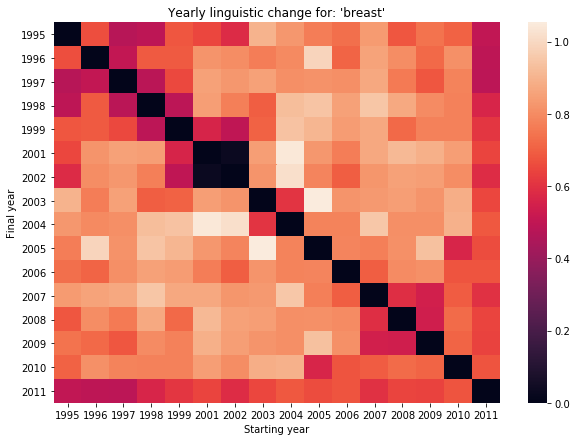

In [79]:
targetWord = 'breast'

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

combination


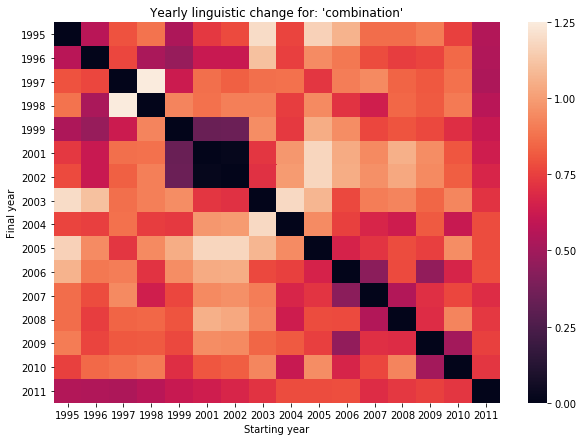

In [80]:
targetWord = 'combination'

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

In [81]:
def findDiverence(word, embeddingsDict):
    cats = sorted(set(embeddingsDict.keys()))
    
    dists = []
    for embed in embeddingsDict[cats[0]][1:]:
        dists.append(1 - sklearn.metrics.pairwise.cosine_similarity(np.expand_dims(embeddingsDict[cats[0]][0][word], axis = 0), np.expand_dims(embed[word], axis = 0))[0,0])
    return sum(dists)

def findMostDivergent(embeddingsDict):
    words = []
    for embeds in embeddingsDict.values():
        for embed in embeds:
            words += list(embed.wv.vocab.keys())
    words = set(words)
    print("Found {} words to compare".format(len(words)))
    return sorted([(w, findDiverence(w, embeddingsDict)) for w in words], key = lambda x: x[1], reverse=True)
    

In [82]:
wordDivergences = findMostDivergent(comparedEmbeddings)

Found 1571 words to compare


The most divergent words are:

In [83]:
wordDivergences[:20]

[('t', 13.179612953215837),
 ('toxicity', 13.154180981218815),
 ('ml', 13.01737873442471),
 ('+', 12.853400095365942),
 ('activity', 12.749210256617516),
 ('infusion', 12.687976829707623),
 ('paclitaxel', 12.683675490319729),
 ('n', 12.662226218730211),
 ('great', 12.659880327060819),
 ('level', 12.559175675734878),
 ('x', 12.508285094052553),
 ('phase', 12.495868034660816),
 ('cisplatin', 12.456645250320435),
 ('combination', 12.417438723146915),
 ('c', 12.407136777415872),
 ('p', 12.399663124466315),
 ('efficacy', 12.373506214469671),
 ('csf', 12.333098318078555),
 ('show', 12.330282736569643),
 ('iv', 12.321207114960998)]

And the least:

In [84]:
wordDivergences[-20:]

[('answer', 1.7252497673034668),
 ('device', 1.721915602684021),
 ('facilitate', 1.720019280910492),
 ('additionally', 1.685628592967987),
 ('particular', 1.6720524430274963),
 ('ensure', 1.6524746417999268),
 ('context', 1.650183618068695),
 ('definition', 1.6107643842697144),
 ('difficulty', 1.6012009978294373),
 ('discuss', 1.5829300284385681),
 ('call', 1.5171823501586914),
 ('traditional', 1.4596245288848877),
 ('nature', 1.44323068857193),
 ('constitute', 1.4302696585655212),
 ('simple', 1.410505771636963),
 ('practical', 1.3745331764221191),
 ('special', 1.294035017490387),
 ('uncertain', 1.2042807936668396),
 ('situation', 1.1920225620269775),
 ('view', 1.1317378878593445)]

t


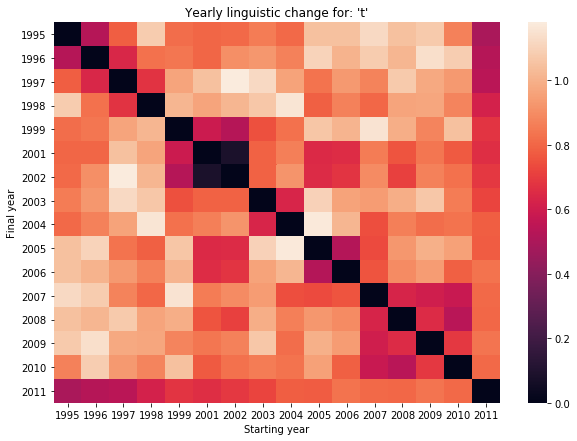

In [85]:
targetWord = wordDivergences[0][0]

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

view


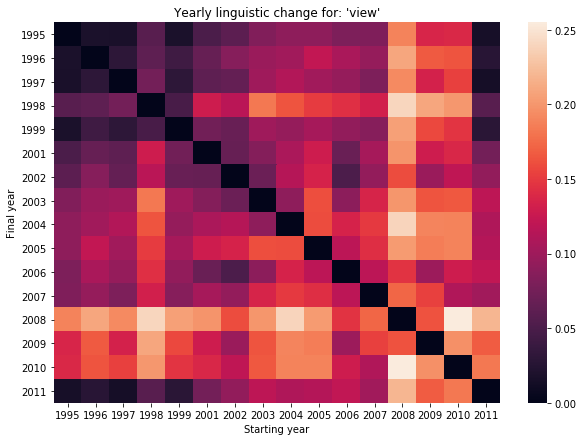

In [86]:
targetWord = wordDivergences[-1][0]

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

## COHA

COHA is a historial dataset so it ends up being a good choice to try the same analysis we just did across three different time periods.

We will be using the same data loading procedure as the last notebook, so go through the process to make sure you know what's going on.

In [88]:
corpora_address = "/Users/bhargavvader/Downloads/Academics_Tech/corpora/COHA"

In [89]:
coha_texts = lucem_illud_2020.loadDavies(corpora_address, return_raw=True)

text_1940s_bsw.zip
text_1920s_gte.zip
text_1900s_mse.zip
text_1810s_kso.zip
text_2000s_scc.zip
text_1910s_jue.zip
text_1890s_jsq.zip
text_1870s_vuy.zip
text_1840s_nsq.zip
text_1860s_psi.zip
text_1950s_ndz.zip
text_1820s_jsi.zip
text_1980s_bkk.zip
text_1930s_bie.zip
text_1960s_xus.zip
text_1990s_bsj.zip
text_1830s_bsu.zip
text_1850s_jpr.zip
text_1970s_jfy.zip
text_1880s_azz.zip


Cool - let us now create our different epochs. This is an important step: I will be using the same 5 epochs I did in the DTM example, but you are recommended to play around with this. I will create a dataframe which logs the year and the genre.

In [114]:
coha_df = pandas.DataFrame(columns=["Year", "Genre", "Epoch", "normalized sents"])

In [115]:
for article in coha_texts:
    genre, year, id_ = article.split("_")

    year = int(year)
    
    if year > 1810 and year < 1880:
        epoch = 0
    if year >= 1880 and year < 1913:
        epoch = 1
    if year >= 1913 and year < 1950:
        epoch = 2
    if year >= 1950 and year < 1990:
        epoch = 3
    if year >= 1990:
        epoch = 4
    
    try:
        if len(coha_texts[article][2]) < 1500000:
            token_sents = [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(coha_texts[article][2].decode("utf-8"))]
            normalized_sents = [lucem_illud_2020.normalizeTokens(s, lemma=False) for s in token_sents]
            coha_df.loc[id_] = [year, genre, epoch, normalized_sents]
    except TypeError:
        continue
    except IndexError:
        continue


We can now arrange our word embeddings by either year, genre, or epoch, and see how the words in each of those contexts change.

In [176]:
rawEmbeddings_epoch = rawModels(coha_df, 'Epoch', text_column_name='normalized sents')

In [ ]:
# rawEmbeddings_genre = rawModels(coha_df, 'Genre', text_column_name='normalized sents')

We now have the raw embeddings for epoch and genre. You can test out the previous analysis on words of your choice.

In [178]:
for epoch, embedding in enumerate(rawEmbeddings_epoch):
    model = rawEmbeddings_epoch[embedding]
    name = "embedding_epoch_" + str(epoch)
    model.save(name)

In [ ]:
# for embedding in rawEmbeddings_genre:
#     model = rawEmbeddings_genre[embedding]
#     name = "embedding_genre_" + embedding
#     model.save(name)

In [179]:
from gensim.models import Word2Vec

In [191]:
def file_to_embeddings(address, kind):
    rawEmbeddings = {}
    for file in os.listdir(address):
        if "embedding_"+kind in file:
            e, kind_, kind_type = file.split("_")
            kind_type = eval(kind_type)
            rawEmbeddings[kind_type] = Word2Vec.load(file)
    return rawEmbeddings

In [192]:
# rawEmbeddings_genre_load = file_to_embeddings(".", "genre")

In [193]:
rawEmbeddings_epoch_load = file_to_embeddings(".", "epoch")

In [194]:
rawEmbeddings_epoch_load.keys()

dict_keys([0, 1, 2, 3, 4])

In [195]:
rawEmbeddings_epoch, compared_epoch = compareModels(coha_df, 'Epoch', text_column_name='normalized sents', embeddings_raw=rawEmbeddings_epoch_load)

In [ ]:
# rawEmbeddings_genre, compared_genre = compareModels(coha_df, 'Genre', text_column_name='normalized sents', embeddings_raw=rawEmbeddings_genre_load)

You now have access to the epoch wise embeddings, and the code to train models genre wise (commented out). 
You can use the original embeddings, the compared embeddings and such to perform the analysis we did before.

## <span style="color:red">*Exercise 4b*</span>

<span style="color:red">**Do only 4a or 4b.** Construct cells immediately below this that align word embeddings over time or across domains/corpora. Interrogate the spaces that result and ask which words changed most and least over the entire period or between contexts/corpora. What does this reveal about the social game underlying your space? 
    
    
### Discourse Atom Model
    
The following code demonstrates a way to model topics using word embeddings, and is based on the paper: Discourses of Death: Introducing a new method to model topics in word embeddings," by Alina Arseniev-Koehler, Susan Cochran, Vickie Mays, and Jacob G. Foster. (Draft available upon request from May 15, 2020)
    
The code is included to demonstrate the technique.

In [2]:
from __future__ import division
from gensim.models import Word2Vec
import pandas as pd
import cython
import gensim
import math
import pickle
from scipy.linalg import norm
from sklearn.preprocessing import normalize
%matplotlib inline
from scipy.stats import entropy
from sklearn.metrics.pairwise import cosine_similarity
from seaborn import boxplot 
from nltk.tokenize import word_tokenize
from itertools import combinations
import matplotlib.pyplot as plt
import pandas as pd
#import pandas_profiling
import numpy as np

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
#from spellchecker import SpellChecker
from gensim.test.utils import datapath 
import re
import string, re
import cython

import numpy as np 
from gensim import corpora, models, similarities #calc all similarities at once, from http://radimrehurek.com/gensim/tut3.html
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import Word2Vec, KeyedVectors
from random import seed, sample
from ksvd import ApproximateKSVD #pip or conda install ksvd #this is key!

#some of these not needed, clean up last step

In [26]:
# w2vmodel = Word2Vec.load('embedding_genre_fic')
w2vmodel = KeyedVectors.load_word2vec_format("../data/GoogleNews-vectors-negative300.bin", limit=25730, binary=True)

In [4]:
#len(w2vmodel.wv.vocab) #vocabulary size (recall that words had to be included at least 10x to be in this model)
#w2vmodel.wv.most_similar('she', topn=25) 

In [27]:
#### TRAIN MODEL:

#n_comp: Number of topics (i.e., atoms, or dictionary elements)
#n_nonzeros: Number of nonzero coefficients to target (how many atoms each word can load onto)
            
            
def do_aksvd(w2vmodel, n_comp, n_nonzeros, save=False, savelocation='../data/aksvd_models/'): #set for Alina's files, switch to where you want save the model
    #https://github.com/nel215/ksvd #takes about 2 min on Alina's laptop for 30 atoms 
    aksvd_t = ApproximateKSVD(n_components=n_comp, transform_n_nonzero_coefs=n_nonzeros) #also may adjuste n iter which is default at 10, and tolerance for error which is default at  tol=1e-6 #n_components is number of discourse atoms, since vocab size is smallish, keep this fewer. transform_n is the number of atoms (components) that a word can be a linear combo of
    dictionary_t = aksvd_t.fit(w2vmodel.wv.vectors).components_ # Dictionary is the matrix of discourse atoms. 
    alpha_t = aksvd_t.transform(w2vmodel.wv.vectors) #get the alphas, which are the "weights" of each word on a discourse atoms

    if save==True:
        outfile = open(str(savelocation) + '200d_' + str(n_comp) + 'comp' + str(n_nonzeros) + 'nonzeros_aksvd_nvdrsdf20','wb')
        pickle.dump(aksvd_t,outfile)
        outfile.close()
        
        outfile = open(str(savelocation) + '200d_' +str(n_comp) + 'comp' + str(n_nonzeros) + 'nonzeros_dictionary_nvdrsdf20','wb')
        pickle.dump(dictionary_t,outfile)
        outfile.close()
        
        outfile = open(str(savelocation) + '200d_' + str(n_comp) + 'comp' + str(n_nonzeros) + 'nonzeros_alpha_nvdrsdf20','wb')
        pickle.dump(alpha_t,outfile)
        outfile.close()
    return(dictionary_t, alpha_t)

Two quick quality checks. These are useful to choose the number of atoms in the dictionary (i.e., number of topics): $R^2$ and Topic Diversity

* Useful to look at product of the two since $R^2$ tends to increase with higher # topics, as Topic Diversity decreases. Intuition: more topics can better explain the original semantic space, but also then these topics are less distinct from one another; we want a balance between these two. 

In [28]:
#reconstruction quality, including R^2:
def reconst_qual(w2vmodel, dictionary_mat, alpha_mat):
    #reconstruct the word vectors
    reconstructed = alpha_mat.dot(dictionary_mat) #reconstruct word vectors and add back in mean(?). but note that reconstructed norm is still around 0-1, not 1, is that an issue?
    #e1 = norm(w2vmodel.wv.vectors - reconstructed) #total reconstruction error, larger means MORE error. norm as specified here takes frobenius norm of error matrix.


    #total VARIANCE in the data: sum of squares 
    squares3= w2vmodel.wv.vectors-np.mean(w2vmodel.wv.vectors, axis=1).reshape(-1,1) #https://dziganto.github.io/data%20science/linear%20regression/machine%20learning/python/Linear-Regression-101-Metrics/
    #sst3= np.sum([i.dot(i) for i in squares3] ) #same as below

    sst3= np.sum(np.square(squares3))


    #total sum of squared ERRORS/residuals
    e3= [reconstructed[i]-w2vmodel.wv.vectors[i] for i in range(0,len(w2vmodel.wv.vectors))]  #https://dziganto.github.io/data%20science/linear%20regression/machine%20learning/python/Linear-Regression-101-Metrics/
    #sse3= np.sum([i.dot(i) for i in e3] ) #same as below
    sse3= np.sum(np.square(e3))

    #R^2: 1- (SSE / SST )
    r2= 1- (sse3 /  sst3) #https://stats.stackexchange.com/questions/184603/in-pca-what-is-the-connection-between-explained-variance-and-squared-error


    #compute root mean square error
    rmse=  math.sqrt(np.mean(np.square(e3)))



    return(sse3, rmse, r2) #https://stats.stackexchange.com/questions/184603/in-pca-what-is-the-connection-between-explained-variance-and-squared-error


In [29]:
#topic diversity (% unique words among total closest 25 words to each atom)

def topic_diversity(w2vmodel, dictionary_mat, top_n=25):

    topwords=[] #list of list, each innter list includes top N words in that topic

    for i in range(0, len(dictionary_mat)): #set to number of total topics
        topwords.extend([i[0] for i in w2vmodel.wv.similar_by_vector(dictionary_mat[i],topn=top_n)]) #set for top N words 
        #print(w2vmodel.wv.similar_by_vector(dictionary[i],topn=N))

    uniquewords= set(topwords)
    diversity = len(uniquewords)/len(topwords)
    return(diversity)


Usage example

In [30]:
dictionary, alpha = do_aksvd(w2vmodel, 150, 5, save=True)

/Users/bhargavvader/open_source/Content-Analysis-2020/venv/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  # Remove the CWD from sys.path while we load stuff.
/Users/bhargavvader/open_source/Content-Analysis-2020/venv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  # This is added back by InteractiveShellApp.init_path()


In [31]:
topic_diversity(w2vmodel, dictionary, top_n=25)

/Users/bhargavvader/open_source/Content-Analysis-2020/venv/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


0.9290666666666667

In [32]:
reconst_qual(w2vmodel, dictionary, alpha)

/Users/bhargavvader/open_source/Content-Analysis-2020/venv/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  if __name__ == '__main__':
/Users/bhargavvader/open_source/Content-Analysis-2020/venv/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  app.launch_new_instance()


(174778.21804219662, 0.15047457768205016, 0.4066059203624073)

**Explore a Trained Discourse Atom Topic Model**

In [33]:
#loading back in the model pieces if not already in

infile = open('../data/aksvd_models/200d_150comp5nonzeros_dictionary_nvdrsdf20','rb')
dictionary=pickle.load(infile)
infile.close()

infile = open('../data/aksvd_models/200d_150comp5nonzeros_aksvd_nvdrsdf20','rb')
aksvd=pickle.load(infile)
infile.close()

infile = open('../data/aksvd_models/200d_150comp5nonzeros_alpha_nvdrsdf20','rb')
alpha=pickle.load(infile)
infile.close()

For each atom, look at the most similar words.

In [34]:
for i in range(0, len(dictionary)):
    print("Discourse_Atom " + str(i))
    print([i[0] for i in w2vmodel.wv.similar_by_vector(dictionary[i],topn=25)]) #what are the most similar words to the Nth
    #print([i[0] for i in w2vmodel.wv.similar_by_vector(-dictionary[i],topn=25)]) #what are the most similar words to the Nth dicourse atom?
    print('\n')
    
#for a specific atom, e.g., 112th atom look at 25 most similar words:
#w2vmodel.wv.similar_by_vector(dictionary[112],topn=25)

Discourse_Atom 0
['thunderstorms', 'rain', 'precipitation', 'heavy_rain', 'temperatures', 'snowfall', 'rainfall', 'winds', 'rains', 'weather', 'showers', 'snow', 'National_Weather_Service', 'storms', 'Temperatures', 'colder', 'heavy_rains', 'gusts', 'upper_##s', 'humidity', 'windy', 'frost', 'meteorologist', 'forecasters', 'moisture']


Discourse_Atom 1
['ore', 'mining', 'mine', 'geological', 'Mine', 'mineralization', 'Mining', 'mined', 'mines', 'mineral', 'exploration', 'drilling', 'copper', 'minerals', 'miner', 'uranium', 'zinc', 'gold', 'geology', 'Minerals', 'drill', 'miners', 'Drilling', 'Mines', 'Mineral']


Discourse_Atom 2
['killings', 'shootings', 'attacks', 'massacre', 'explosions', 'bombings', 'deaths', 'murders', 'assaults', 'blasts', 'bombing', 'incidents', 'carnage', 'suicide_bombings', 'violence', 'suicide_bombing', 'killing', 'slayings', 'bloodshed', 'attack', 'fatalities', 'killed', 'rioting', 'clashes', 'gunshots']


Discourse_Atom 3
['OSU', 'Purdue', 'MSU', 'OU', 'KU

/Users/bhargavvader/open_source/Content-Analysis-2020/venv/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  This is separate from the ipykernel package so we can avoid doing imports until


['election', 'elections', 'electoral', 'polls', 'parliamentary_elections', 'elected', 'electorate', 'votes', 'candidate', 'vote', 'reelection', 'constituencies', 'incumbent', 'Democratic_Party', 'candidacy', 'Election', 'caucus', 'newly_elected', 'primaries', 'candidates', 'voters', 'party', 'Elections', 'independents', 'voter_turnout']


Discourse_Atom 42
['Rainbow', 'Cool', 'Dragon', 'Friendly', 'Crazy', 'Touch', 'Own', 'Dog', 'Blue', 'Hand', 'Pure', 'Purple', 'Cat', 'Eye', 'Soul', 'Pink', 'Green', 'Heart', 'Kid', 'Perfect', 'Dream', 'Light', 'Ultimate', 'Diamond', 'Mega']


Discourse_Atom 43
['Remember_comment_moderation', 'n_newspaper', 'THE_DOW_JONES_CONTENT', 'invisible_item_flow', 'Optimum_Online_®', 'entirety_via_email', 'containing_inappropriate_links_obscenities', 'BREAKING_NEWS_UPDATE', '##.##_plus_GST', 'Video_More_>>', 'newsday.com', 'Charlotte_Observer_welcomes', 'Short_Term_PowerRatings', 'expressly_prohibited_without', 'Personalized_Mock_Up_Frontpages', 'RTT_Staff_Write

['published_broadcast_rewritten', 'respective_owners', 'trademarks', 'registered_trademarks', 'registered_trademark', 'redistributed', 'prior_written_consent', 'informational_purposes', 'rights_reserved', 'profanity_obscenity_spam', 'use_profanities_vulgarities', 'reproduced', 'reprinted', 'herein', 'contained_herein', 'Please_refrain', 'Copyright_c', 'libelous', 'completeness', 'Privacy_Policy', 'affiliates', 'historical_facts', 'repeat_violators', 'material_objectionable', 'defamatory']


Discourse_Atom 92
['grateful', 'proud', 'delighted', 'thrilled', 'pleased', 'glad', 'excited', 'appreciative', 'congratulate', 'thanked', 'thankful', 'encouraged', 'thank', 'commend', 'honored', 'happy', 'eager', 'applaud', 'diligently', 'wished', 'wish', 'invited', 'elated', 'congratulated', 'thanking']


Discourse_Atom 93
['adapter', 'Bluetooth', 'devices', 'device', 'LCD', 'optical', 'projector', 'sensor', 'USB', 'LED', 'handheld', 'wireless', 'portable', 'antenna', 'router', 'touchscreen', 'lapt

Look at how a word "loads" onto atoms, based on the nonzeros (i.e., alpha)

In [35]:
print(w2vmodel.wv.vocab.get('the').index, '\n', alpha[w2vmodel.wv.vocab.get('the').index])

#useful relevant code:
#w2vmodel.wv.index2word[3452]
#w2vmodel.wv.most_similar('the', topn=15)
#np.where(alpha[w2vmodel.wv.vocab.get('the').index] != 0) #get index where the loading of a word onto discourse atoms is not 0

11 
 [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.20014136
  0.          0.          0.          0.23509231  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.26077554  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.        

/Users/bhargavvader/open_source/Content-Analysis-2020/venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.
